In [1]:
!nvidia-smi

Fri Mar  1 17:41:15 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   48C    P8    18W / 170W |    339MiB / 12288MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('../../')
os.getcwd()

'/home/bunny/projects/IConNet'

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold4/'

cuda


In [7]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [8]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [9]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [10]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m13mfcc_sm.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M13(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')

name: M13mfcc
description: FirConv with fftconv
mfcc:
  n_mfcc: 40
  n_fft: 512
  hop_length: 128
  n_mels: 64
  sample_rate: 16000
pooling: mean
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)
total parameters: 77394


In [11]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [12]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [13]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                      | 0.004123711340206186/10 [00:01<51:27, 308.89s/it]

Train Epoch: 1 [0/11481 (0%)]	Loss: 0.652037
Mem before-during-after: 389120 9054720 18361856


  1%|▌                                                                       | 0.08659793814432996/10 [00:08<14:44, 89.24s/it]

Train Epoch: 1 [1280/11481 (11%)]	Loss: 0.293123
Mem before-during-after: 18361856 18506752 18361856


  2%|█▏                                                                      | 0.16907216494845365/10 [00:16<14:34, 88.99s/it]

Train Epoch: 1 [2560/11481 (22%)]	Loss: 0.683640
Mem before-during-after: 18361856 18506752 18361856


  3%|█▊                                                                       | 0.2515463917525771/10 [00:23<14:29, 89.20s/it]

Train Epoch: 1 [3840/11481 (34%)]	Loss: 0.069138
Mem before-during-after: 18361856 18506752 18361856


  3%|██▍                                                                      | 0.3340206185567005/10 [00:30<14:49, 92.06s/it]

Train Epoch: 1 [5120/11481 (45%)]	Loss: 0.716215
Mem before-during-after: 18361856 18506752 18361856


  4%|██▉                                                                     | 0.41649484536082393/10 [00:38<14:26, 90.37s/it]

Train Epoch: 1 [6400/11481 (56%)]	Loss: 0.563169
Mem before-during-after: 18361856 18506752 18361856


  5%|███▌                                                                    | 0.49896907216494735/10 [00:45<13:58, 88.27s/it]

Train Epoch: 1 [7680/11481 (67%)]	Loss: 0.469611
Mem before-during-after: 18361856 18506752 18361856


  6%|████▏                                                                    | 0.5814432989690708/10 [00:53<13:51, 88.25s/it]

Train Epoch: 1 [8960/11481 (78%)]	Loss: 0.400628
Mem before-during-after: 18361856 18506752 18361856


  7%|████▊                                                                    | 0.6639175257731942/10 [01:00<14:02, 90.24s/it]

Train Epoch: 1 [10240/11481 (89%)]	Loss: 0.904560
Mem before-during-after: 18361856 18506752 18361856


 10%|███████▎                                                                 | 1.0020618556701002/10 [01:30<13:12, 88.05s/it]


Test Epoch: 1	Accuracy: 3036/4064 (74%)

Train Epoch: 2 [0/11481 (0%)]	Loss: 0.040275
Mem before-during-after: 18360832 18506752 18361856


 11%|███████▉                                                                 | 1.0865979381443267/10 [01:37<13:13, 88.99s/it]

Train Epoch: 2 [1280/11481 (11%)]	Loss: 0.026083
Mem before-during-after: 18361856 18506752 18361856


 12%|████████▌                                                                | 1.1690721649484501/10 [01:45<13:11, 89.66s/it]

Train Epoch: 2 [2560/11481 (22%)]	Loss: 0.643886
Mem before-during-after: 18361856 18506752 18361856


 13%|█████████▏                                                               | 1.2515463917525735/10 [01:52<13:00, 89.24s/it]

Train Epoch: 2 [3840/11481 (34%)]	Loss: 0.059584
Mem before-during-after: 18361856 18506752 18361856


 13%|█████████▊                                                                | 1.334020618556697/10 [01:59<12:53, 89.22s/it]

Train Epoch: 2 [5120/11481 (45%)]	Loss: 1.074276
Mem before-during-after: 18361856 18506752 18361856


 14%|██████████▎                                                              | 1.4164948453608204/10 [02:07<12:39, 88.54s/it]

Train Epoch: 2 [6400/11481 (56%)]	Loss: 0.532408
Mem before-during-after: 18361856 18506752 18361856


 15%|██████████▉                                                              | 1.4989690721649438/10 [02:14<12:29, 88.15s/it]

Train Epoch: 2 [7680/11481 (67%)]	Loss: 0.196514
Mem before-during-after: 18361856 18506752 18361856


 16%|███████████▌                                                             | 1.5814432989690672/10 [02:21<12:16, 87.47s/it]

Train Epoch: 2 [8960/11481 (78%)]	Loss: 0.552475
Mem before-during-after: 18361856 18506752 18361856


 17%|████████████▏                                                            | 1.6639175257731906/10 [02:29<12:09, 87.55s/it]

Train Epoch: 2 [10240/11481 (89%)]	Loss: 0.394099
Mem before-during-after: 18361856 18506752 18361856


 20%|██████████████▊                                                           | 2.002061855670097/10 [02:58<11:35, 86.98s/it]


Test Epoch: 2	Accuracy: 3520/4064 (86%)

Train Epoch: 3 [0/11481 (0%)]	Loss: 0.006557
Mem before-during-after: 18360832 18506752 18361856


 21%|███████████████▏                                                         | 2.0865979381443234/10 [03:05<11:33, 87.58s/it]

Train Epoch: 3 [1280/11481 (11%)]	Loss: 0.000574
Mem before-during-after: 18361856 18506752 18361856


 22%|████████████████                                                          | 2.169072164948447/10 [03:13<11:34, 88.62s/it]

Train Epoch: 3 [2560/11481 (22%)]	Loss: 0.437244
Mem before-during-after: 18361856 18506752 18361856


 23%|████████████████▉                                                          | 2.25154639175257/10 [03:20<11:25, 88.43s/it]

Train Epoch: 3 [3840/11481 (34%)]	Loss: 0.046811
Mem before-during-after: 18361856 18506752 18361856


 23%|█████████████████                                                        | 2.3340206185566936/10 [03:27<11:22, 89.00s/it]

Train Epoch: 3 [5120/11481 (45%)]	Loss: 1.244419
Mem before-during-after: 18361856 18506752 18361856


 24%|█████████████████▉                                                        | 2.416494845360817/10 [03:35<11:10, 88.38s/it]

Train Epoch: 3 [6400/11481 (56%)]	Loss: 0.442887
Mem before-during-after: 18361856 18506752 18361856


 25%|██████████████████▏                                                      | 2.4989690721649405/10 [03:42<10:59, 87.91s/it]

Train Epoch: 3 [7680/11481 (67%)]	Loss: 0.291003
Mem before-during-after: 18361856 18506752 18361856


 26%|███████████████████                                                       | 2.581443298969064/10 [03:49<10:47, 87.31s/it]

Train Epoch: 3 [8960/11481 (78%)]	Loss: 0.215372
Mem before-during-after: 18361856 18506752 18361856


 27%|███████████████████▍                                                     | 2.6639175257731873/10 [03:56<10:42, 87.59s/it]

Train Epoch: 3 [10240/11481 (89%)]	Loss: 0.326086
Mem before-during-after: 18361856 18506752 18361856


 30%|█████████████████████▉                                                   | 3.0020618556700933/10 [04:26<10:07, 86.75s/it]


Test Epoch: 3	Accuracy: 3509/4064 (86%)

Train Epoch: 4 [0/11481 (0%)]	Loss: 0.003357
Mem before-during-after: 18360832 18506752 18361856


 31%|███████████████████████▏                                                   | 3.08659793814432/10 [04:33<10:11, 88.40s/it]

Train Epoch: 4 [1280/11481 (11%)]	Loss: 0.000321
Mem before-during-after: 18361856 18506752 18361856


 32%|███████████████████████▏                                                 | 3.1690721649484432/10 [04:41<10:01, 88.09s/it]

Train Epoch: 4 [2560/11481 (22%)]	Loss: 0.215265
Mem before-during-after: 18361856 18506752 18361856


 33%|███████████████████████▋                                                 | 3.2515463917525667/10 [04:48<10:00, 88.92s/it]

Train Epoch: 4 [3840/11481 (34%)]	Loss: 0.009673
Mem before-during-after: 18361856 18506752 18361856


 33%|█████████████████████████                                                  | 3.33402061855669/10 [04:55<09:50, 88.52s/it]

Train Epoch: 4 [5120/11481 (45%)]	Loss: 0.998516
Mem before-during-after: 18361856 18506752 18361856


 34%|████████████████████████▉                                                | 3.4164948453608135/10 [05:03<09:40, 88.18s/it]

Train Epoch: 4 [6400/11481 (56%)]	Loss: 0.347936
Mem before-during-after: 18361856 18506752 18361856


 35%|█████████████████████████▉                                                | 3.498969072164937/10 [05:10<09:28, 87.37s/it]

Train Epoch: 4 [7680/11481 (67%)]	Loss: 0.136752
Mem before-during-after: 18361856 18506752 18361856


 36%|██████████████████████████▏                                              | 3.5814432989690603/10 [05:17<09:25, 88.15s/it]

Train Epoch: 4 [8960/11481 (78%)]	Loss: 0.221666
Mem before-during-after: 18361856 18506752 18361856


 37%|██████████████████████████▋                                              | 3.6639175257731837/10 [05:24<09:57, 94.31s/it]

Train Epoch: 4 [10240/11481 (89%)]	Loss: 0.372217
Mem before-during-after: 18361856 18506752 18361856


 40%|██████████████████████████████                                             | 4.00206185567009/10 [05:54<08:39, 86.66s/it]


Test Epoch: 4	Accuracy: 3410/4064 (83%)

Train Epoch: 5 [0/11481 (0%)]	Loss: 0.010232
Mem before-during-after: 18360832 18506752 18361856


 41%|██████████████████████████████▏                                           | 4.086597938144316/10 [06:01<08:37, 87.49s/it]

Train Epoch: 5 [1280/11481 (11%)]	Loss: 0.000395
Mem before-during-after: 18361856 18506752 18361856


 42%|███████████████████████████████▎                                           | 4.16907216494844/10 [06:09<08:28, 87.13s/it]

Train Epoch: 5 [2560/11481 (22%)]	Loss: 0.186462
Mem before-during-after: 18361856 18506752 18361856


 43%|███████████████████████████████▍                                          | 4.251546391752563/10 [06:16<08:20, 87.14s/it]

Train Epoch: 5 [3840/11481 (34%)]	Loss: 0.011833
Mem before-during-after: 18361856 18506752 18361856


 43%|███████████████████████████████▋                                         | 4.3340206185566865/10 [06:23<08:12, 86.92s/it]

Train Epoch: 5 [5120/11481 (45%)]	Loss: 1.405731
Mem before-during-after: 18361856 18506752 18361856


 44%|█████████████████████████████████                                          | 4.41649484536081/10 [06:30<08:08, 87.49s/it]

Train Epoch: 5 [6400/11481 (56%)]	Loss: 0.286714
Mem before-during-after: 18361856 18506752 18361856


 45%|█████████████████████████████████▎                                        | 4.498969072164933/10 [06:37<08:01, 87.48s/it]

Train Epoch: 5 [7680/11481 (67%)]	Loss: 0.136625
Mem before-during-after: 18361856 18506752 18361856


 46%|█████████████████████████████████▉                                        | 4.581443298969057/10 [06:45<07:53, 87.42s/it]

Train Epoch: 5 [8960/11481 (78%)]	Loss: 0.271642
Mem before-during-after: 18361856 18506752 18361856


 47%|██████████████████████████████████▉                                        | 4.66391752577318/10 [06:52<07:43, 86.95s/it]

Train Epoch: 5 [10240/11481 (89%)]	Loss: 0.384270
Mem before-during-after: 18361856 18506752 18361856


 50%|█████████████████████████████████████                                     | 5.002061855670086/10 [07:21<07:15, 87.05s/it]


Test Epoch: 5	Accuracy: 3508/4064 (86%)

Train Epoch: 6 [0/11481 (0%)]	Loss: 0.007070
Mem before-during-after: 18360832 18506752 18361856


 51%|█████████████████████████████████████▋                                    | 5.086597938144313/10 [07:28<07:13, 88.24s/it]

Train Epoch: 6 [1280/11481 (11%)]	Loss: 0.000364
Mem before-during-after: 18361856 18506752 18361856


 52%|██████████████████████████████████████▎                                   | 5.169072164948436/10 [07:36<07:07, 88.55s/it]

Train Epoch: 6 [2560/11481 (22%)]	Loss: 0.158980
Mem before-during-after: 18361856 18506752 18361856


 53%|██████████████████████████████████████▎                                  | 5.2515463917525596/10 [07:43<06:56, 87.70s/it]

Train Epoch: 6 [3840/11481 (34%)]	Loss: 0.013251
Mem before-during-after: 18361856 18506752 18361856


 53%|███████████████████████████████████████▍                                  | 5.334020618556683/10 [07:50<06:51, 88.17s/it]

Train Epoch: 6 [5120/11481 (45%)]	Loss: 1.414696
Mem before-during-after: 18361856 18506752 18361856


 54%|████████████████████████████████████████                                  | 5.416494845360806/10 [07:58<06:41, 87.60s/it]

Train Epoch: 6 [6400/11481 (56%)]	Loss: 0.191075
Mem before-during-after: 18361856 18506752 18361856


 55%|█████████████████████████████████████████▏                                 | 5.49896907216493/10 [08:05<06:31, 87.06s/it]

Train Epoch: 6 [7680/11481 (67%)]	Loss: 0.015242
Mem before-during-after: 18361856 18506752 18361856


 56%|█████████████████████████████████████████▎                                | 5.581443298969053/10 [08:12<06:26, 87.49s/it]

Train Epoch: 6 [8960/11481 (78%)]	Loss: 0.181918
Mem before-during-after: 18361856 18506752 18361856


 57%|█████████████████████████████████████████▉                                | 5.663917525773177/10 [08:19<06:20, 87.82s/it]

Train Epoch: 6 [10240/11481 (89%)]	Loss: 0.262240
Mem before-during-after: 18361856 18506752 18361856


 60%|████████████████████████████████████████████▍                             | 6.002061855670083/10 [08:49<05:47, 86.96s/it]


Test Epoch: 6	Accuracy: 3459/4064 (85%)

Train Epoch: 7 [0/11481 (0%)]	Loss: 0.015008
Mem before-during-after: 18360832 18506752 18361856


 61%|█████████████████████████████████████████████                             | 6.086597938144309/10 [08:56<05:42, 87.57s/it]

Train Epoch: 7 [1280/11481 (11%)]	Loss: 0.000118
Mem before-during-after: 18361856 18506752 18361856


 62%|█████████████████████████████████████████████▋                            | 6.169072164948433/10 [09:03<05:33, 87.16s/it]

Train Epoch: 7 [2560/11481 (22%)]	Loss: 0.121913
Mem before-during-after: 18361856 18506752 18361856


 63%|██████████████████████████████████████████████▎                           | 6.251546391752556/10 [09:11<05:27, 87.30s/it]

Train Epoch: 7 [3840/11481 (34%)]	Loss: 0.027831
Mem before-during-after: 18361856 18506752 18361856


 63%|██████████████████████████████████████████████▊                           | 6.334020618556679/10 [09:18<05:28, 89.66s/it]

Train Epoch: 7 [5120/11481 (45%)]	Loss: 1.237256
Mem before-during-after: 18361856 18506752 18361856


 64%|███████████████████████████████████████████████▍                          | 6.416494845360803/10 [09:25<05:12, 87.33s/it]

Train Epoch: 7 [6400/11481 (56%)]	Loss: 0.183147
Mem before-during-after: 18361856 18506752 18361856


 65%|████████████████████████████████████████████████                          | 6.498969072164926/10 [09:32<05:06, 87.58s/it]

Train Epoch: 7 [7680/11481 (67%)]	Loss: 0.069996
Mem before-during-after: 18361856 18506752 18361856


 66%|█████████████████████████████████████████████████▎                         | 6.58144329896905/10 [09:40<04:58, 87.38s/it]

Train Epoch: 7 [8960/11481 (78%)]	Loss: 0.202534
Mem before-during-after: 18361856 18506752 18361856


 67%|█████████████████████████████████████████████████▎                        | 6.663917525773173/10 [09:47<04:52, 87.56s/it]

Train Epoch: 7 [10240/11481 (89%)]	Loss: 0.860881
Mem before-during-after: 18361856 18506752 18361856


 70%|███████████████████████████████████████████████████▊                      | 7.002061855670079/10 [10:16<04:19, 86.48s/it]


Test Epoch: 7	Accuracy: 3487/4064 (85%)

Train Epoch: 8 [0/11481 (0%)]	Loss: 0.010564
Mem before-during-after: 18360832 18506752 18361856


 71%|████████████████████████████████████████████████████▍                     | 7.086597938144306/10 [10:23<04:16, 87.96s/it]

Train Epoch: 8 [1280/11481 (11%)]	Loss: 0.002766
Mem before-during-after: 18361856 18506752 18361856


 72%|█████████████████████████████████████████████████████                     | 7.169072164948429/10 [10:31<04:06, 87.16s/it]

Train Epoch: 8 [2560/11481 (22%)]	Loss: 0.285624
Mem before-during-after: 18361856 18506752 18361856


 73%|████████████████████████████████████████████████████▉                    | 7.2515463917525524/10 [10:38<04:01, 87.98s/it]

Train Epoch: 8 [3840/11481 (34%)]	Loss: 0.001949
Mem before-during-after: 18361856 18506752 18361856


 73%|██████████████████████████████████████████████████████▎                   | 7.334020618556676/10 [10:45<03:53, 87.77s/it]

Train Epoch: 8 [5120/11481 (45%)]	Loss: 1.364403
Mem before-during-after: 18361856 18506752 18361856


 74%|██████████████████████████████████████████████████████▉                   | 7.416494845360799/10 [10:52<03:44, 87.06s/it]

Train Epoch: 8 [6400/11481 (56%)]	Loss: 0.265980
Mem before-during-after: 18361856 18506752 18361856


 75%|███████████████████████████████████████████████████████▍                  | 7.498969072164923/10 [11:00<03:41, 88.52s/it]

Train Epoch: 8 [7680/11481 (67%)]	Loss: 0.059690
Mem before-during-after: 18361856 18506752 18361856


 76%|████████████████████████████████████████████████████████                  | 7.581443298969046/10 [11:07<03:30, 86.92s/it]

Train Epoch: 8 [8960/11481 (78%)]	Loss: 0.236137
Mem before-during-after: 18361856 18506752 18361856


 77%|███████████████████████████████████████████████████████▉                 | 7.6639175257731695/10 [11:14<03:24, 87.50s/it]

Train Epoch: 8 [10240/11481 (89%)]	Loss: 0.447016
Mem before-during-after: 18361856 18506752 18361856


 80%|███████████████████████████████████████████████████████████▏              | 8.002061855670076/10 [11:43<02:53, 86.64s/it]


Test Epoch: 8	Accuracy: 3503/4064 (86%)

Train Epoch: 9 [0/11481 (0%)]	Loss: 0.001855
Mem before-during-after: 18360832 18506752 18361856


 81%|███████████████████████████████████████████████████████████▊              | 8.086597938144303/10 [11:51<02:49, 88.66s/it]

Train Epoch: 9 [1280/11481 (11%)]	Loss: 0.000267
Mem before-during-after: 18361856 18506752 18361856


 82%|████████████████████████████████████████████████████████████▍             | 8.169072164948426/10 [11:58<02:39, 87.34s/it]

Train Epoch: 9 [2560/11481 (22%)]	Loss: 0.305698
Mem before-during-after: 18361856 18506752 18361856


 83%|█████████████████████████████████████████████████████████████▉             | 8.25154639175255/10 [12:05<02:32, 87.04s/it]

Train Epoch: 9 [3840/11481 (34%)]	Loss: 0.001751
Mem before-during-after: 18361856 18506752 18361856


 83%|█████████████████████████████████████████████████████████████▋            | 8.334020618556673/10 [12:12<02:24, 86.97s/it]

Train Epoch: 9 [5120/11481 (45%)]	Loss: 0.993372
Mem before-during-after: 18361856 18506752 18361856


 84%|██████████████████████████████████████████████████████████████▎           | 8.416494845360797/10 [12:20<02:17, 86.98s/it]

Train Epoch: 9 [6400/11481 (56%)]	Loss: 0.156835
Mem before-during-after: 18361856 18506752 18361856


 85%|███████████████████████████████████████████████████████████████▋           | 8.49896907216492/10 [12:27<02:10, 86.92s/it]

Train Epoch: 9 [7680/11481 (67%)]	Loss: 0.172947
Mem before-during-after: 18361856 18506752 18361856


 86%|███████████████████████████████████████████████████████████████▌          | 8.581443298969043/10 [12:34<02:03, 87.40s/it]

Train Epoch: 9 [8960/11481 (78%)]	Loss: 0.135755
Mem before-during-after: 18361856 18506752 18361856


 87%|████████████████████████████████████████████████████████████████          | 8.663917525773167/10 [12:41<01:56, 87.12s/it]

Train Epoch: 9 [10240/11481 (89%)]	Loss: 0.367599
Mem before-during-after: 18361856 18506752 18361856


 90%|██████████████████████████████████████████████████████████████████▌       | 9.002061855670073/10 [13:11<01:26, 86.87s/it]


Test Epoch: 9	Accuracy: 3502/4064 (86%)

Train Epoch: 10 [0/11481 (0%)]	Loss: 0.007667
Mem before-during-after: 18360832 18506752 18361856


 91%|█████████████████████████████████████████████████████████████████████       | 9.0865979381443/10 [13:18<01:21, 88.72s/it]

Train Epoch: 10 [1280/11481 (11%)]	Loss: 0.001915
Mem before-during-after: 18361856 18506752 18361856


 92%|███████████████████████████████████████████████████████████████████▊      | 9.169072164948423/10 [13:25<01:12, 87.81s/it]

Train Epoch: 10 [2560/11481 (22%)]	Loss: 0.186479
Mem before-during-after: 18361856 18506752 18361856


 93%|████████████████████████████████████████████████████████████████████▍     | 9.251546391752546/10 [13:33<01:05, 87.83s/it]

Train Epoch: 10 [3840/11481 (34%)]	Loss: 0.001569
Mem before-during-after: 18361856 18506752 18361856


 93%|██████████████████████████████████████████████████████████████████████     | 9.33402061855667/10 [13:40<00:58, 88.41s/it]

Train Epoch: 10 [5120/11481 (45%)]	Loss: 0.732568
Mem before-during-after: 18361856 18506752 18361856


 94%|█████████████████████████████████████████████████████████████████████▋    | 9.416494845360793/10 [13:47<00:52, 89.39s/it]

Train Epoch: 10 [6400/11481 (56%)]	Loss: 0.173341
Mem before-during-after: 18361856 18506752 18361856


 95%|██████████████████████████████████████████████████████████████████████▎   | 9.498969072164916/10 [13:55<00:44, 88.30s/it]

Train Epoch: 10 [7680/11481 (67%)]	Loss: 0.068977
Mem before-during-after: 18361856 18506752 18361856


 96%|███████████████████████████████████████████████████████████████████████▊   | 9.58144329896904/10 [14:02<00:36, 88.19s/it]

Train Epoch: 10 [8960/11481 (78%)]	Loss: 0.256922
Mem before-during-after: 18361856 18506752 18361856


 97%|███████████████████████████████████████████████████████████████████████▌  | 9.663917525773163/10 [14:09<00:29, 87.78s/it]

Train Epoch: 10 [10240/11481 (89%)]	Loss: 0.165479
Mem before-during-after: 18361856 18506752 18361856


100%|█████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [14:38<00:00, 87.89s/it]


Test Epoch: 10	Accuracy: 3459/4064 (85%)



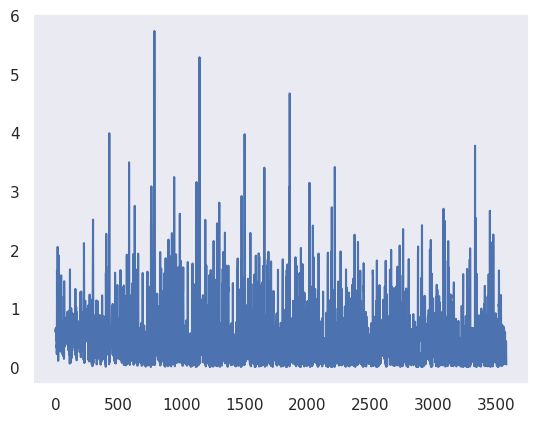

In [14]:
plt.plot(train_losses)

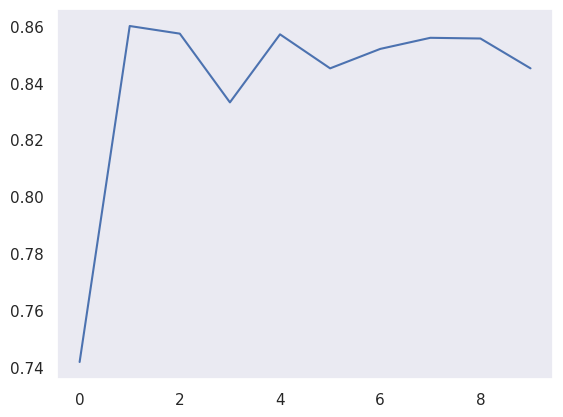

In [15]:
plt.plot(test_accuracy)

In [16]:
model_dir = '../models_physio/'
model_path = f'{model_dir}physio16k_fold4_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [17]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [18]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3460/4064 (0.8514)
{'acc_detail': tensor([0.8285, 0.8585], device='cuda:0'),
 'acc_unweighted': tensor(0.8435, device='cuda:0'),
 'acc_weighted': tensor(0.8514, device='cuda:0'),
 'f1s_detail': tensor([0.7264, 0.8980], device='cuda:0'),
 'f1s_unweighted': tensor(0.8122, device='cuda:0'),
 'f1s_weighted': tensor(0.8571, device='cuda:0'),
 'precision_detail': tensor([0.6468, 0.9412], device='cuda:0'),
 'recall_detail': tensor([0.8285, 0.8585], device='cuda:0'),
 'rocauc': tensor(0.9230, device='cuda:0'),
 'rocauc_detail': tensor([0.9230, 0.9230], device='cuda:0'),
 'uar': tensor(0.8435, device='cuda:0'),
 'wap': tensor(0.8711, device='cuda:0')}


tensor([[ 802,  166],
        [ 438, 2658]], device='cuda:0')

In [19]:
n_epoch = 10
n_epoch2 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                     | 0.004123711340206186/50 [00:00<1:19:13, 95.08s/it]

Train Epoch: 11 [0/11481 (0%)]	Loss: 0.029448
Mem before-during-after: 17893888 18039808 18516480


  0%|                                                                      | 0.08659793814432996/50 [00:08<1:18:34, 94.46s/it]

Train Epoch: 11 [1280/11481 (11%)]	Loss: 0.016435
Mem before-during-after: 18516480 18661376 18516480


  0%|▏                                                                     | 0.16907216494845365/50 [00:15<1:18:06, 94.05s/it]

Train Epoch: 11 [2560/11481 (22%)]	Loss: 0.255579
Mem before-during-after: 18516480 18661376 18516480


  1%|▎                                                                      | 0.2515463917525771/50 [00:23<1:18:14, 94.37s/it]

Train Epoch: 11 [3840/11481 (34%)]	Loss: 0.077299
Mem before-during-after: 18516480 18661376 18516480


  1%|▍                                                                      | 0.3340206185567005/50 [00:31<1:17:56, 94.16s/it]

Train Epoch: 11 [5120/11481 (45%)]	Loss: 0.549745
Mem before-during-after: 18516480 18661376 18516480


  1%|▌                                                                     | 0.41649484536082393/50 [00:39<1:18:06, 94.51s/it]

Train Epoch: 11 [6400/11481 (56%)]	Loss: 0.134354
Mem before-during-after: 18516480 18661376 18516480


  1%|▋                                                                     | 0.49896907216494735/50 [00:47<1:18:16, 94.88s/it]

Train Epoch: 11 [7680/11481 (67%)]	Loss: 0.055184
Mem before-during-after: 18516480 18661376 18516480


  1%|▊                                                                      | 0.5814432989690708/50 [00:54<1:17:39, 94.28s/it]

Train Epoch: 11 [8960/11481 (78%)]	Loss: 0.189699
Mem before-during-after: 18516480 18661376 18516480


  1%|▉                                                                      | 0.6639175257731942/50 [01:02<1:17:55, 94.78s/it]

Train Epoch: 11 [10240/11481 (89%)]	Loss: 0.023336
Mem before-during-after: 18516480 18661376 18516480


  2%|█▍                                                                     | 1.0020618556701002/50 [01:34<1:16:31, 93.71s/it]


Test Epoch: 11	Accuracy: 3590/4064 (88%)

Train Epoch: 12 [0/11481 (0%)]	Loss: 0.010558
Mem before-during-after: 18515456 18661376 18516480


  2%|█▌                                                                     | 1.0865979381443267/50 [01:42<1:17:19, 94.86s/it]

Train Epoch: 12 [1280/11481 (11%)]	Loss: 0.001829
Mem before-during-after: 18516480 18661376 18516480


  2%|█▋                                                                     | 1.1690721649484501/50 [01:50<1:16:33, 94.07s/it]

Train Epoch: 12 [2560/11481 (22%)]	Loss: 0.200050
Mem before-during-after: 18516480 18661376 18516480


  3%|█▊                                                                     | 1.2515463917525735/50 [01:57<1:17:32, 95.45s/it]

Train Epoch: 12 [3840/11481 (34%)]	Loss: 0.087644
Mem before-during-after: 18516480 18661376 18516480


  3%|█▉                                                                      | 1.334020618556697/50 [02:05<1:16:44, 94.60s/it]

Train Epoch: 12 [5120/11481 (45%)]	Loss: 0.536455
Mem before-during-after: 18516480 18661376 18516480


  3%|██                                                                     | 1.4164948453608204/50 [02:13<1:16:31, 94.50s/it]

Train Epoch: 12 [6400/11481 (56%)]	Loss: 0.140446
Mem before-during-after: 18516480 18661376 18516480


  3%|██▏                                                                    | 1.4989690721649438/50 [02:21<1:17:06, 95.38s/it]

Train Epoch: 12 [7680/11481 (67%)]	Loss: 0.045376
Mem before-during-after: 18516480 18661376 18516480


  3%|██▏                                                                    | 1.5814432989690672/50 [02:29<1:15:50, 93.98s/it]

Train Epoch: 12 [8960/11481 (78%)]	Loss: 0.181042
Mem before-during-after: 18516480 18661376 18516480


  3%|██▎                                                                    | 1.6639175257731906/50 [02:36<1:15:21, 93.54s/it]

Train Epoch: 12 [10240/11481 (89%)]	Loss: 0.036519
Mem before-during-after: 18516480 18661376 18516480


  4%|██▉                                                                     | 2.002061855670097/50 [03:08<1:14:18, 92.90s/it]


Test Epoch: 12	Accuracy: 3597/4064 (88%)

Train Epoch: 13 [0/11481 (0%)]	Loss: 0.009925
Mem before-during-after: 18515456 18661376 18516480


  4%|██▉                                                                    | 2.0865979381443234/50 [03:16<1:15:23, 94.41s/it]

Train Epoch: 13 [1280/11481 (11%)]	Loss: 0.000980
Mem before-during-after: 18516480 18661376 18516480


  4%|███                                                                     | 2.169072164948447/50 [03:24<1:15:19, 94.48s/it]

Train Epoch: 13 [2560/11481 (22%)]	Loss: 0.140978
Mem before-during-after: 18516480 18661376 18516480


  5%|███▎                                                                     | 2.25154639175257/50 [03:32<1:15:56, 95.44s/it]

Train Epoch: 13 [3840/11481 (34%)]	Loss: 0.102280
Mem before-during-after: 18516480 18661376 18516480


  5%|███▎                                                                   | 2.3340206185566936/50 [03:39<1:15:54, 95.55s/it]

Train Epoch: 13 [5120/11481 (45%)]	Loss: 0.459781
Mem before-during-after: 18516480 18661376 18516480


  5%|███▍                                                                    | 2.416494845360817/50 [03:47<1:14:14, 93.61s/it]

Train Epoch: 13 [6400/11481 (56%)]	Loss: 0.113780
Mem before-during-after: 18516480 18661376 18516480


  5%|███▌                                                                   | 2.4989690721649405/50 [03:55<1:15:08, 94.91s/it]

Train Epoch: 13 [7680/11481 (67%)]	Loss: 0.045549
Mem before-during-after: 18516480 18661376 18516480


  5%|███▋                                                                    | 2.579381443298961/50 [04:03<1:18:04, 98.79s/it]

Train Epoch: 13 [8960/11481 (78%)]	Loss: 0.199340
Mem before-during-after: 18516480 18661376 18516480


  5%|███▊                                                                   | 2.6639175257731873/50 [04:11<1:16:21, 96.78s/it]

Train Epoch: 13 [10240/11481 (89%)]	Loss: 0.031720
Mem before-during-after: 18516480 18661376 18516480


  6%|████▎                                                                  | 2.9999999999999902/50 [04:43<1:13:42, 94.11s/it]


Test Epoch: 13	Accuracy: 3572/4064 (87%)



  6%|████▎                                                                  | 3.0041237113401964/50 [04:43<1:15:15, 96.09s/it]

Train Epoch: 14 [0/11481 (0%)]	Loss: 0.006887
Mem before-during-after: 18515456 18661376 18516480


  6%|████▌                                                                    | 3.08659793814432/50 [04:51<1:13:33, 94.07s/it]

Train Epoch: 14 [1280/11481 (11%)]	Loss: 0.000530
Mem before-during-after: 18516480 18661376 18516480


  6%|████▌                                                                    | 3.16701030927834/50 [04:59<1:16:36, 98.15s/it]

Train Epoch: 14 [2560/11481 (22%)]	Loss: 0.120836
Mem before-during-after: 18516480 18661376 18516480


  7%|████▌                                                                  | 3.2515463917525667/50 [05:07<1:13:42, 94.59s/it]

Train Epoch: 14 [3840/11481 (34%)]	Loss: 0.087178
Mem before-during-after: 18516480 18661376 18516480


  7%|████▊                                                                    | 3.33402061855669/50 [05:15<1:13:36, 94.64s/it]

Train Epoch: 14 [5120/11481 (45%)]	Loss: 0.404975
Mem before-during-after: 18516480 18661376 18516480


  7%|████▊                                                                  | 3.4164948453608135/50 [05:23<1:13:30, 94.67s/it]

Train Epoch: 14 [6400/11481 (56%)]	Loss: 0.104379
Mem before-during-after: 18516480 18661376 18516480


  7%|█████                                                                   | 3.498969072164937/50 [05:31<1:13:11, 94.43s/it]

Train Epoch: 14 [7680/11481 (67%)]	Loss: 0.053602
Mem before-during-after: 18516480 18661376 18516480


  7%|█████                                                                  | 3.5814432989690603/50 [05:39<1:13:33, 95.08s/it]

Train Epoch: 14 [8960/11481 (78%)]	Loss: 0.172767
Mem before-during-after: 18516480 18661376 18516480


  7%|█████▏                                                                 | 3.6639175257731837/50 [05:46<1:12:47, 94.26s/it]

Train Epoch: 14 [10240/11481 (89%)]	Loss: 0.024789
Mem before-during-after: 18516480 18661376 18516480


  8%|█████▊                                                                   | 4.00206185567009/50 [06:18<1:12:31, 94.61s/it]


Test Epoch: 14	Accuracy: 3574/4064 (87%)

Train Epoch: 15 [0/11481 (0%)]	Loss: 0.005713
Mem before-during-after: 18515456 18661376 18516480


  8%|█████▉                                                                  | 4.086597938144316/50 [06:26<1:12:05, 94.22s/it]

Train Epoch: 15 [1280/11481 (11%)]	Loss: 0.000447
Mem before-during-after: 18516480 18661376 18516480


  8%|██████                                                                   | 4.16907216494844/50 [06:34<1:12:05, 94.38s/it]

Train Epoch: 15 [2560/11481 (22%)]	Loss: 0.122893
Mem before-during-after: 18516480 18661376 18516480


  9%|██████                                                                  | 4.251546391752563/50 [06:42<1:12:00, 94.45s/it]

Train Epoch: 15 [3840/11481 (34%)]	Loss: 0.073258
Mem before-during-after: 18516480 18661376 18516480


  9%|██████▏                                                                | 4.3340206185566865/50 [06:50<1:12:09, 94.80s/it]

Train Epoch: 15 [5120/11481 (45%)]	Loss: 0.408278
Mem before-during-after: 18516480 18661376 18516480


  9%|██████▍                                                                  | 4.41649484536081/50 [06:57<1:11:42, 94.39s/it]

Train Epoch: 15 [6400/11481 (56%)]	Loss: 0.085764
Mem before-during-after: 18516480 18661376 18516480


  9%|██████▍                                                                 | 4.498969072164933/50 [07:05<1:12:06, 95.10s/it]

Train Epoch: 15 [7680/11481 (67%)]	Loss: 0.038165
Mem before-during-after: 18516480 18661376 18516480


  9%|██████▌                                                                 | 4.581443298969057/50 [07:13<1:11:18, 94.19s/it]

Train Epoch: 15 [8960/11481 (78%)]	Loss: 0.157527
Mem before-during-after: 18516480 18661376 18516480


  9%|██████▋                                                                 | 4.661855670103077/50 [07:21<1:11:24, 94.50s/it]

Train Epoch: 15 [10240/11481 (89%)]	Loss: 0.021334
Mem before-during-after: 18516480 18661376 18516480


 10%|███████▏                                                                | 5.002061855670086/50 [07:53<1:10:03, 93.41s/it]


Test Epoch: 15	Accuracy: 3577/4064 (87%)

Train Epoch: 16 [0/11481 (0%)]	Loss: 0.004196
Mem before-during-after: 18515456 18661376 18516480


 10%|███████▎                                                                | 5.086597938144313/50 [08:01<1:11:04, 94.94s/it]

Train Epoch: 16 [1280/11481 (11%)]	Loss: 0.000268
Mem before-during-after: 18516480 18661376 18516480


 10%|███████▍                                                                | 5.169072164948436/50 [08:09<1:12:00, 96.38s/it]

Train Epoch: 16 [2560/11481 (22%)]	Loss: 0.138279
Mem before-during-after: 18516480 18661376 18516480


 11%|███████▍                                                               | 5.2515463917525596/50 [08:17<1:11:30, 95.89s/it]

Train Epoch: 16 [3840/11481 (34%)]	Loss: 0.068140
Mem before-during-after: 18516480 18661376 18516480


 11%|███████▋                                                                | 5.334020618556683/50 [08:24<1:10:20, 94.49s/it]

Train Epoch: 16 [5120/11481 (45%)]	Loss: 0.418113
Mem before-during-after: 18516480 18661376 18516480


 11%|███████▊                                                                | 5.416494845360806/50 [08:32<1:10:01, 94.25s/it]

Train Epoch: 16 [6400/11481 (56%)]	Loss: 0.072043
Mem before-during-after: 18516480 18661376 18516480


 11%|████████                                                                 | 5.49896907216493/50 [08:40<1:10:05, 94.51s/it]

Train Epoch: 16 [7680/11481 (67%)]	Loss: 0.030480
Mem before-during-after: 18516480 18661376 18516480


 11%|████████                                                                | 5.581443298969053/50 [08:48<1:09:59, 94.55s/it]

Train Epoch: 16 [8960/11481 (78%)]	Loss: 0.181161
Mem before-during-after: 18516480 18661376 18516480


 11%|████████▏                                                               | 5.663917525773177/50 [08:56<1:10:15, 95.09s/it]

Train Epoch: 16 [10240/11481 (89%)]	Loss: 0.025624
Mem before-during-after: 18516480 18661376 18516480


 12%|████████▋                                                               | 6.002061855670083/50 [09:28<1:08:58, 94.06s/it]


Test Epoch: 16	Accuracy: 3558/4064 (87%)

Train Epoch: 17 [0/11481 (0%)]	Loss: 0.002015
Mem before-during-after: 18515456 18661376 18516480


 12%|████████▊                                                               | 6.086597938144309/50 [09:36<1:10:13, 95.95s/it]

Train Epoch: 17 [1280/11481 (11%)]	Loss: 0.000175
Mem before-during-after: 18516480 18661376 18516480


 12%|████████▉                                                               | 6.169072164948433/50 [09:44<1:09:33, 95.22s/it]

Train Epoch: 17 [2560/11481 (22%)]	Loss: 0.146723
Mem before-during-after: 18516480 18661376 18516480


 13%|█████████                                                               | 6.251546391752556/50 [09:51<1:10:45, 97.04s/it]

Train Epoch: 17 [3840/11481 (34%)]	Loss: 0.062305
Mem before-during-after: 18516480 18661376 18516480


 13%|█████████                                                               | 6.334020618556679/50 [09:59<1:09:28, 95.47s/it]

Train Epoch: 17 [5120/11481 (45%)]	Loss: 0.374918
Mem before-during-after: 18516480 18661376 18516480


 13%|█████████▏                                                              | 6.416494845360803/50 [10:07<1:09:07, 95.16s/it]

Train Epoch: 17 [6400/11481 (56%)]	Loss: 0.070063
Mem before-during-after: 18516480 18661376 18516480


 13%|█████████▎                                                              | 6.498969072164926/50 [10:15<1:09:29, 95.85s/it]

Train Epoch: 17 [7680/11481 (67%)]	Loss: 0.017640
Mem before-during-after: 18516480 18661376 18516480


 13%|█████████▌                                                               | 6.58144329896905/50 [10:23<1:08:50, 95.14s/it]

Train Epoch: 17 [8960/11481 (78%)]	Loss: 0.140576
Mem before-during-after: 18516480 18661376 18516480


 13%|█████████▌                                                              | 6.663917525773173/50 [10:31<1:07:58, 94.10s/it]

Train Epoch: 17 [10240/11481 (89%)]	Loss: 0.011147
Mem before-during-after: 18516480 18661376 18516480


 14%|██████████                                                              | 7.002061855670079/50 [11:03<1:07:16, 93.88s/it]


Test Epoch: 17	Accuracy: 3583/4064 (88%)

Train Epoch: 18 [0/11481 (0%)]	Loss: 0.003400
Mem before-during-after: 18515456 18661376 18516480


 14%|██████████▏                                                             | 7.086597938144306/50 [11:10<1:07:21, 94.18s/it]

Train Epoch: 18 [1280/11481 (11%)]	Loss: 0.000205
Mem before-during-after: 18516480 18661376 18516480


 14%|██████████▎                                                             | 7.169072164948429/50 [11:18<1:06:57, 93.81s/it]

Train Epoch: 18 [2560/11481 (22%)]	Loss: 0.132828
Mem before-during-after: 18516480 18661376 18516480


 15%|██████████▎                                                            | 7.2515463917525524/50 [11:26<1:06:59, 94.02s/it]

Train Epoch: 18 [3840/11481 (34%)]	Loss: 0.063155
Mem before-during-after: 18516480 18661376 18516480


 15%|██████████▌                                                             | 7.334020618556676/50 [11:34<1:07:04, 94.33s/it]

Train Epoch: 18 [5120/11481 (45%)]	Loss: 0.334861
Mem before-during-after: 18516480 18661376 18516480


 15%|██████████▋                                                             | 7.416494845360799/50 [11:41<1:06:23, 93.55s/it]

Train Epoch: 18 [6400/11481 (56%)]	Loss: 0.078370
Mem before-during-after: 18516480 18661376 18516480


 15%|██████████▊                                                             | 7.498969072164923/50 [11:49<1:06:17, 93.58s/it]

Train Epoch: 18 [7680/11481 (67%)]	Loss: 0.027088
Mem before-during-after: 18516480 18661376 18516480


 15%|██████████▉                                                             | 7.581443298969046/50 [11:57<1:06:09, 93.57s/it]

Train Epoch: 18 [8960/11481 (78%)]	Loss: 0.153943
Mem before-during-after: 18516480 18661376 18516480


 15%|██████████▉                                                            | 7.6639175257731695/50 [12:05<1:06:10, 93.78s/it]

Train Epoch: 18 [10240/11481 (89%)]	Loss: 0.010395
Mem before-during-after: 18516480 18661376 18516480


 16%|███████████▌                                                            | 8.002061855670076/50 [12:36<1:05:39, 93.81s/it]


Test Epoch: 18	Accuracy: 3548/4064 (87%)

Train Epoch: 19 [0/11481 (0%)]	Loss: 0.002579
Mem before-during-after: 18515456 18661376 18516480


 16%|███████████▋                                                            | 8.086597938144303/50 [12:44<1:05:52, 94.30s/it]

Train Epoch: 19 [1280/11481 (11%)]	Loss: 0.000177
Mem before-during-after: 18516480 18661376 18516480


 16%|███████████▊                                                            | 8.169072164948426/50 [12:52<1:05:38, 94.15s/it]

Train Epoch: 19 [2560/11481 (22%)]	Loss: 0.138802
Mem before-during-after: 18516480 18661376 18516480


 17%|████████████                                                             | 8.25154639175255/50 [13:00<1:05:58, 94.82s/it]

Train Epoch: 19 [3840/11481 (34%)]	Loss: 0.061363
Mem before-during-after: 18516480 18661376 18516480


 17%|████████████                                                            | 8.334020618556673/50 [13:08<1:05:25, 94.22s/it]

Train Epoch: 19 [5120/11481 (45%)]	Loss: 0.419752
Mem before-during-after: 18516480 18661376 18516480


 17%|████████████                                                            | 8.416494845360797/50 [13:16<1:04:53, 93.63s/it]

Train Epoch: 19 [6400/11481 (56%)]	Loss: 0.094609
Mem before-during-after: 18516480 18661376 18516480


 17%|████████████▍                                                            | 8.49896907216492/50 [13:23<1:04:43, 93.57s/it]

Train Epoch: 19 [7680/11481 (67%)]	Loss: 0.040643
Mem before-during-after: 18516480 18661376 18516480


 17%|████████████▎                                                           | 8.581443298969043/50 [13:31<1:05:23, 94.74s/it]

Train Epoch: 19 [8960/11481 (78%)]	Loss: 0.167377
Mem before-during-after: 18516480 18661376 18516480


 17%|████████████▍                                                           | 8.663917525773167/50 [13:39<1:05:12, 94.64s/it]

Train Epoch: 19 [10240/11481 (89%)]	Loss: 0.005342
Mem before-during-after: 18516480 18661376 18516480


 18%|████████████▉                                                           | 9.002061855670073/50 [14:11<1:04:35, 94.53s/it]


Test Epoch: 19	Accuracy: 3543/4064 (87%)

Train Epoch: 20 [0/11481 (0%)]	Loss: 0.003614
Mem before-during-after: 18515456 18661376 18516480


 18%|█████████████▍                                                            | 9.0865979381443/50 [14:19<1:04:58, 95.30s/it]

Train Epoch: 20 [1280/11481 (11%)]	Loss: 0.000151
Mem before-during-after: 18516480 18661376 18516480


 18%|█████████████▏                                                          | 9.169072164948423/50 [14:27<1:04:52, 95.32s/it]

Train Epoch: 20 [2560/11481 (22%)]	Loss: 0.126812
Mem before-during-after: 18516480 18661376 18516480


 19%|█████████████▎                                                          | 9.251546391752546/50 [14:34<1:04:51, 95.49s/it]

Train Epoch: 20 [3840/11481 (34%)]	Loss: 0.050703
Mem before-during-after: 18516480 18661376 18516480


 19%|█████████████▋                                                           | 9.33402061855667/50 [14:42<1:04:15, 94.82s/it]

Train Epoch: 20 [5120/11481 (45%)]	Loss: 0.436237
Mem before-during-after: 18516480 18661376 18516480


 19%|█████████████▌                                                          | 9.416494845360793/50 [14:50<1:04:31, 95.40s/it]

Train Epoch: 20 [6400/11481 (56%)]	Loss: 0.070226
Mem before-during-after: 18516480 18661376 18516480


 19%|█████████████▋                                                          | 9.498969072164916/50 [14:58<1:03:55, 94.70s/it]

Train Epoch: 20 [7680/11481 (67%)]	Loss: 0.008211
Mem before-during-after: 18516480 18661376 18516480


 19%|█████████████▉                                                           | 9.58144329896904/50 [15:06<1:03:35, 94.41s/it]

Train Epoch: 20 [8960/11481 (78%)]	Loss: 0.134203
Mem before-during-after: 18516480 18661376 18516480


 19%|█████████████▉                                                          | 9.663917525773163/50 [15:14<1:03:34, 94.56s/it]

Train Epoch: 20 [10240/11481 (89%)]	Loss: 0.003330
Mem before-during-after: 18516480 18661376 18516480


 20%|██████████████▍                                                         | 10.00206185567007/50 [15:45<1:02:44, 94.12s/it]


Test Epoch: 20	Accuracy: 3566/4064 (87%)

Train Epoch: 21 [0/11481 (0%)]	Loss: 0.005236
Mem before-during-after: 18515456 18661376 18516480


 20%|██████████████▎                                                        | 10.086597938144296/50 [15:53<1:02:51, 94.49s/it]

Train Epoch: 21 [1280/11481 (11%)]	Loss: 0.000246
Mem before-during-after: 18516480 18661376 18516480


 20%|██████████████▋                                                         | 10.16907216494842/50 [16:01<1:02:42, 94.47s/it]

Train Epoch: 21 [2560/11481 (22%)]	Loss: 0.146092
Mem before-during-after: 18516480 18661376 18516480


 21%|██████████████▌                                                        | 10.251546391752543/50 [16:09<1:05:44, 99.23s/it]

Train Epoch: 21 [3840/11481 (34%)]	Loss: 0.048715
Mem before-during-after: 18516480 18661376 18516480


 21%|██████████████▋                                                        | 10.334020618556666/50 [16:17<1:02:43, 94.88s/it]

Train Epoch: 21 [5120/11481 (45%)]	Loss: 0.452854
Mem before-during-after: 18516480 18661376 18516480


 21%|██████████████▉                                                         | 10.41649484536079/50 [16:25<1:02:17, 94.42s/it]

Train Epoch: 21 [6400/11481 (56%)]	Loss: 0.063536
Mem before-during-after: 18516480 18661376 18516480


 21%|██████████████▉                                                        | 10.498969072164913/50 [16:33<1:02:23, 94.77s/it]

Train Epoch: 21 [7680/11481 (67%)]	Loss: 0.002915
Mem before-during-after: 18516480 18661376 18516480


 21%|███████████████                                                        | 10.581443298969036/50 [16:40<1:02:14, 94.74s/it]

Train Epoch: 21 [8960/11481 (78%)]	Loss: 0.122290
Mem before-during-after: 18516480 18661376 18516480


 21%|███████████████▎                                                        | 10.66391752577316/50 [16:48<1:01:58, 94.54s/it]

Train Epoch: 21 [10240/11481 (89%)]	Loss: 0.002537
Mem before-during-after: 18516480 18661376 18516480


 22%|███████████████▌                                                       | 11.002061855670066/50 [17:20<1:01:32, 94.68s/it]


Test Epoch: 21	Accuracy: 3576/4064 (87%)

Train Epoch: 22 [0/11481 (0%)]	Loss: 0.008221
Mem before-during-after: 18515456 18661376 18516480


 22%|███████████████▋                                                       | 11.086597938144292/50 [17:28<1:01:15, 94.46s/it]

Train Epoch: 22 [1280/11481 (11%)]	Loss: 0.000227
Mem before-during-after: 18516480 18661376 18516480


 22%|███████████████▊                                                       | 11.169072164948416/50 [17:36<1:00:40, 93.76s/it]

Train Epoch: 22 [2560/11481 (22%)]	Loss: 0.109461
Mem before-during-after: 18516480 18661376 18516480


 23%|████████████████▏                                                       | 11.25154639175254/50 [17:43<1:00:56, 94.36s/it]

Train Epoch: 22 [3840/11481 (34%)]	Loss: 0.049058
Mem before-during-after: 18516480 18661376 18516480


 23%|████████████████                                                       | 11.334020618556663/50 [17:51<1:00:58, 94.62s/it]

Train Epoch: 22 [5120/11481 (45%)]	Loss: 0.402918
Mem before-during-after: 18516480 18661376 18516480


 23%|████████████████▏                                                      | 11.416494845360786/50 [17:59<1:00:23, 93.90s/it]

Train Epoch: 22 [6400/11481 (56%)]	Loss: 0.089884
Mem before-during-after: 18516480 18661376 18516480


 23%|████████████████▌                                                       | 11.49896907216491/50 [18:07<1:00:52, 94.88s/it]

Train Epoch: 22 [7680/11481 (67%)]	Loss: 0.008739
Mem before-during-after: 18516480 18661376 18516480


 23%|████████████████▍                                                      | 11.581443298969033/50 [18:15<1:00:37, 94.68s/it]

Train Epoch: 22 [8960/11481 (78%)]	Loss: 0.136640
Mem before-during-after: 18516480 18661376 18516480


 23%|████████████████▌                                                      | 11.663917525773156/50 [18:22<1:00:12, 94.23s/it]

Train Epoch: 22 [10240/11481 (89%)]	Loss: 0.003156
Mem before-during-after: 18516480 18661376 18516480


 24%|█████████████████▌                                                       | 12.002061855670062/50 [18:54<59:19, 93.66s/it]


Test Epoch: 22	Accuracy: 3585/4064 (88%)

Train Epoch: 23 [0/11481 (0%)]	Loss: 0.006364
Mem before-during-after: 18515456 18661376 18516480


 24%|█████████████████▋                                                       | 12.086597938144289/50 [19:02<59:34, 94.29s/it]

Train Epoch: 23 [1280/11481 (11%)]	Loss: 0.000593
Mem before-during-after: 18516480 18661376 18516480


 24%|█████████████████▊                                                       | 12.169072164948412/50 [19:10<59:30, 94.38s/it]

Train Epoch: 23 [2560/11481 (22%)]	Loss: 0.125545
Mem before-during-after: 18516480 18661376 18516480


 25%|█████████████████▉                                                       | 12.251546391752536/50 [19:18<59:02, 93.85s/it]

Train Epoch: 23 [3840/11481 (34%)]	Loss: 0.046621
Mem before-during-after: 18516480 18661376 18516480


 25%|██████████████████                                                       | 12.334020618556659/50 [19:26<59:17, 94.44s/it]

Train Epoch: 23 [5120/11481 (45%)]	Loss: 0.412039
Mem before-during-after: 18516480 18661376 18516480


 25%|██████████████████▏                                                      | 12.416494845360782/50 [19:33<58:49, 93.92s/it]

Train Epoch: 23 [6400/11481 (56%)]	Loss: 0.081357
Mem before-during-after: 18516480 18661376 18516480


 25%|██████████████████▏                                                      | 12.498969072164906/50 [19:41<59:21, 94.96s/it]

Train Epoch: 23 [7680/11481 (67%)]	Loss: 0.007090
Mem before-during-after: 18516480 18661376 18516480


 25%|██████████████████▌                                                       | 12.58144329896903/50 [19:49<59:06, 94.77s/it]

Train Epoch: 23 [8960/11481 (78%)]	Loss: 0.114905
Mem before-during-after: 18516480 18661376 18516480


 25%|██████████████████▍                                                      | 12.663917525773153/50 [19:57<58:48, 94.50s/it]

Train Epoch: 23 [10240/11481 (89%)]	Loss: 0.002448
Mem before-during-after: 18516480 18661376 18516480


 26%|██████████████████▉                                                      | 13.002061855670059/50 [20:28<58:05, 94.22s/it]


Test Epoch: 23	Accuracy: 3573/4064 (87%)

Train Epoch: 24 [0/11481 (0%)]	Loss: 0.005054
Mem before-during-after: 18515456 18661376 18516480


 26%|███████████████████                                                      | 13.086597938144285/50 [20:36<58:21, 94.87s/it]

Train Epoch: 24 [1280/11481 (11%)]	Loss: 0.000406
Mem before-during-after: 18516480 18661376 18516480


 26%|███████████████████▏                                                     | 13.169072164948409/50 [20:44<58:01, 94.51s/it]

Train Epoch: 24 [2560/11481 (22%)]	Loss: 0.101872
Mem before-during-after: 18516480 18661376 18516480


 27%|███████████████████▎                                                     | 13.251546391752532/50 [20:52<57:34, 94.00s/it]

Train Epoch: 24 [3840/11481 (34%)]	Loss: 0.038047
Mem before-during-after: 18516480 18661376 18516480


 27%|███████████████████▍                                                     | 13.334020618556655/50 [21:00<57:49, 94.62s/it]

Train Epoch: 24 [5120/11481 (45%)]	Loss: 0.378605
Mem before-during-after: 18516480 18661376 18516480


 27%|███████████████████▌                                                     | 13.416494845360779/50 [21:08<58:04, 95.25s/it]

Train Epoch: 24 [6400/11481 (56%)]	Loss: 0.071035
Mem before-during-after: 18516480 18661376 18516480


 27%|███████████████████▋                                                     | 13.498969072164902/50 [21:15<57:32, 94.60s/it]

Train Epoch: 24 [7680/11481 (67%)]	Loss: 0.007109
Mem before-during-after: 18516480 18661376 18516480


 27%|███████████████████▊                                                     | 13.579381443298923/50 [21:23<57:34, 94.85s/it]

Train Epoch: 24 [8960/11481 (78%)]	Loss: 0.168606
Mem before-during-after: 18516480 18661376 18516480


 27%|███████████████████▉                                                     | 13.663917525773149/50 [21:31<57:25, 94.81s/it]

Train Epoch: 24 [10240/11481 (89%)]	Loss: 0.002783
Mem before-during-after: 18516480 18661376 18516480


 28%|████████████████████▍                                                    | 14.002061855670055/50 [22:03<55:59, 93.33s/it]


Test Epoch: 24	Accuracy: 3593/4064 (88%)

Train Epoch: 25 [0/11481 (0%)]	Loss: 0.006210
Mem before-during-after: 18515456 18661376 18516480


 28%|████████████████████▌                                                    | 14.086597938144282/50 [22:11<56:43, 94.78s/it]

Train Epoch: 25 [1280/11481 (11%)]	Loss: 0.000561
Mem before-during-after: 18516480 18661376 18516480


 28%|████████████████████▋                                                    | 14.169072164948405/50 [22:19<56:38, 94.85s/it]

Train Epoch: 25 [2560/11481 (22%)]	Loss: 0.107510
Mem before-during-after: 18516480 18661376 18516480


 29%|████████████████████▊                                                    | 14.251546391752528/50 [22:26<56:14, 94.41s/it]

Train Epoch: 25 [3840/11481 (34%)]	Loss: 0.036641
Mem before-during-after: 18516480 18661376 18516480


 29%|████████████████████▉                                                    | 14.334020618556652/50 [22:34<56:07, 94.41s/it]

Train Epoch: 25 [5120/11481 (45%)]	Loss: 0.370527
Mem before-during-after: 18516480 18661376 18516480


 29%|█████████████████████                                                    | 14.416494845360775/50 [22:42<55:48, 94.10s/it]

Train Epoch: 25 [6400/11481 (56%)]	Loss: 0.083239
Mem before-during-after: 18516480 18661376 18516480


 29%|█████████████████████▏                                                   | 14.498969072164899/50 [22:50<55:47, 94.30s/it]

Train Epoch: 25 [7680/11481 (67%)]	Loss: 0.005549
Mem before-during-after: 18516480 18661376 18516480


 29%|█████████████████████▎                                                   | 14.581443298969022/50 [22:57<55:32, 94.10s/it]

Train Epoch: 25 [8960/11481 (78%)]	Loss: 0.503017
Mem before-during-after: 18516480 18661376 18516480


 29%|█████████████████████▍                                                   | 14.663917525773146/50 [23:05<55:22, 94.02s/it]

Train Epoch: 25 [10240/11481 (89%)]	Loss: 0.004000
Mem before-during-after: 18516480 18661376 18516480


 30%|█████████████████████▉                                                   | 15.002061855670052/50 [23:37<54:47, 93.95s/it]


Test Epoch: 25	Accuracy: 3595/4064 (88%)

Train Epoch: 26 [0/11481 (0%)]	Loss: 0.010708
Mem before-during-after: 18515456 18661376 18516480


 30%|██████████████████████                                                   | 15.086597938144278/50 [23:45<54:56, 94.43s/it]

Train Epoch: 26 [1280/11481 (11%)]	Loss: 0.000478
Mem before-during-after: 18516480 18661376 18516480


 30%|██████████████████████▏                                                  | 15.169072164948401/50 [23:53<54:52, 94.54s/it]

Train Epoch: 26 [2560/11481 (22%)]	Loss: 0.077721
Mem before-during-after: 18516480 18661376 18516480


 31%|██████████████████████▎                                                  | 15.251546391752525/50 [24:01<54:44, 94.53s/it]

Train Epoch: 26 [3840/11481 (34%)]	Loss: 0.047793
Mem before-during-after: 18516480 18661376 18516480


 31%|██████████████████████▍                                                  | 15.334020618556648/50 [24:09<54:31, 94.38s/it]

Train Epoch: 26 [5120/11481 (45%)]	Loss: 0.390181
Mem before-during-after: 18516480 18661376 18516480


 31%|██████████████████████▌                                                  | 15.416494845360772/50 [24:16<54:28, 94.52s/it]

Train Epoch: 26 [6400/11481 (56%)]	Loss: 0.080288
Mem before-during-after: 18516480 18661376 18516480


 31%|██████████████████████▋                                                  | 15.498969072164895/50 [24:24<54:37, 95.00s/it]

Train Epoch: 26 [7680/11481 (67%)]	Loss: 0.005140
Mem before-during-after: 18516480 18661376 18516480


 31%|██████████████████████▋                                                  | 15.581443298969019/50 [24:32<54:18, 94.68s/it]

Train Epoch: 26 [8960/11481 (78%)]	Loss: 0.206003
Mem before-during-after: 18516480 18661376 18516480


 31%|██████████████████████▊                                                  | 15.663917525773142/50 [24:40<55:12, 96.47s/it]

Train Epoch: 26 [10240/11481 (89%)]	Loss: 0.002646
Mem before-during-after: 18516480 18661376 18516480


 32%|███████████████████████▋                                                  | 16.00206185567005/50 [25:12<53:18, 94.09s/it]


Test Epoch: 26	Accuracy: 3600/4064 (88%)

Train Epoch: 27 [0/11481 (0%)]	Loss: 0.009783
Mem before-during-after: 18515456 18661376 18516480


 32%|███████████████████████▍                                                 | 16.086597938144276/50 [25:20<53:40, 94.98s/it]

Train Epoch: 27 [1280/11481 (11%)]	Loss: 0.001319
Mem before-during-after: 18516480 18661376 18516480


 32%|████████████████████████▎                                                  | 16.1690721649484/50 [25:28<53:34, 95.01s/it]

Train Epoch: 27 [2560/11481 (22%)]	Loss: 0.084816
Mem before-during-after: 18516480 18661376 18516480


 33%|███████████████████████▋                                                 | 16.251546391752523/50 [25:36<53:06, 94.42s/it]

Train Epoch: 27 [3840/11481 (34%)]	Loss: 0.040896
Mem before-during-after: 18516480 18661376 18516480


 33%|███████████████████████▊                                                 | 16.334020618556647/50 [25:44<52:52, 94.23s/it]

Train Epoch: 27 [5120/11481 (45%)]	Loss: 0.423837
Mem before-during-after: 18516480 18661376 18516480


 33%|████████████████████████▎                                                 | 16.41649484536077/50 [25:51<52:41, 94.14s/it]

Train Epoch: 27 [6400/11481 (56%)]	Loss: 0.083537
Mem before-during-after: 18516480 18661376 18516480


 33%|████████████████████████                                                 | 16.498969072164893/50 [25:59<52:54, 94.75s/it]

Train Epoch: 27 [7680/11481 (67%)]	Loss: 0.004988
Mem before-during-after: 18516480 18661376 18516480


 33%|████████████████████████▏                                                | 16.581443298969017/50 [26:07<52:53, 94.95s/it]

Train Epoch: 27 [8960/11481 (78%)]	Loss: 0.203118
Mem before-during-after: 18516480 18661376 18516480


 33%|████████████████████████▋                                                 | 16.66391752577314/50 [26:15<52:41, 94.83s/it]

Train Epoch: 27 [10240/11481 (89%)]	Loss: 0.002736
Mem before-during-after: 18516480 18661376 18516480


 34%|████████████████████████▊                                                | 17.002061855670046/50 [26:47<51:20, 93.37s/it]


Test Epoch: 27	Accuracy: 3593/4064 (88%)

Train Epoch: 28 [0/11481 (0%)]	Loss: 0.013632
Mem before-during-after: 18515456 18661376 18516480


 34%|████████████████████████▉                                                | 17.086597938144273/50 [26:54<51:36, 94.07s/it]

Train Epoch: 28 [1280/11481 (11%)]	Loss: 0.000574
Mem before-during-after: 18516480 18661376 18516480


 34%|█████████████████████████                                                | 17.169072164948396/50 [27:02<51:18, 93.78s/it]

Train Epoch: 28 [2560/11481 (22%)]	Loss: 0.073626
Mem before-during-after: 18516480 18661376 18516480


 35%|█████████████████████████▌                                                | 17.25154639175252/50 [27:10<51:16, 93.95s/it]

Train Epoch: 28 [3840/11481 (34%)]	Loss: 0.031281
Mem before-during-after: 18516480 18661376 18516480


 35%|█████████████████████████▎                                               | 17.334020618556643/50 [27:18<51:03, 93.79s/it]

Train Epoch: 28 [5120/11481 (45%)]	Loss: 0.400443
Mem before-during-after: 18516480 18661376 18516480


 35%|█████████████████████████▍                                               | 17.416494845360766/50 [27:26<50:58, 93.86s/it]

Train Epoch: 28 [6400/11481 (56%)]	Loss: 0.097787
Mem before-during-after: 18516480 18661376 18516480


 35%|█████████████████████████▉                                                | 17.49896907216489/50 [27:33<51:07, 94.39s/it]

Train Epoch: 28 [7680/11481 (67%)]	Loss: 0.007172
Mem before-during-after: 18516480 18661376 18516480


 35%|█████████████████████████▋                                               | 17.581443298969013/50 [27:41<50:45, 93.95s/it]

Train Epoch: 28 [8960/11481 (78%)]	Loss: 0.245683
Mem before-during-after: 18516480 18661376 18516480


 35%|█████████████████████████▊                                               | 17.663917525773137/50 [27:49<50:51, 94.38s/it]

Train Epoch: 28 [10240/11481 (89%)]	Loss: 0.001689
Mem before-during-after: 18516480 18661376 18516480


 36%|██████████████████████████▎                                              | 18.002061855670043/50 [28:21<50:09, 94.04s/it]


Test Epoch: 28	Accuracy: 3600/4064 (88%)

Train Epoch: 29 [0/11481 (0%)]	Loss: 0.006842
Mem before-during-after: 18515456 18661376 18516480


 36%|██████████████████████████▊                                               | 18.08659793814427/50 [28:29<50:05, 94.17s/it]

Train Epoch: 29 [1280/11481 (11%)]	Loss: 0.002542
Mem before-during-after: 18516480 18661376 18516480


 36%|██████████████████████████▌                                              | 18.169072164948393/50 [28:36<50:11, 94.61s/it]

Train Epoch: 29 [2560/11481 (22%)]	Loss: 0.084388
Mem before-during-after: 18516480 18661376 18516480


 37%|██████████████████████████▋                                              | 18.251546391752516/50 [28:44<49:58, 94.45s/it]

Train Epoch: 29 [3840/11481 (34%)]	Loss: 0.063360
Mem before-during-after: 18516480 18661376 18516480


 37%|███████████████████████████▏                                              | 18.33402061855664/50 [28:52<49:53, 94.52s/it]

Train Epoch: 29 [5120/11481 (45%)]	Loss: 0.396108
Mem before-during-after: 18516480 18661376 18516480


 37%|██████████████████████████▉                                              | 18.416494845360763/50 [29:00<50:02, 95.06s/it]

Train Epoch: 29 [6400/11481 (56%)]	Loss: 0.119827
Mem before-during-after: 18516480 18661376 18516480


 37%|███████████████████████████                                              | 18.498969072164886/50 [29:08<49:39, 94.57s/it]

Train Epoch: 29 [7680/11481 (67%)]	Loss: 0.008409
Mem before-during-after: 18516480 18661376 18516480


 37%|███████████████████████████▌                                              | 18.58144329896901/50 [29:16<49:39, 94.84s/it]

Train Epoch: 29 [8960/11481 (78%)]	Loss: 0.612008
Mem before-during-after: 18516480 18661376 18516480


 37%|███████████████████████████▏                                             | 18.663917525773133/50 [29:23<49:40, 95.13s/it]

Train Epoch: 29 [10240/11481 (89%)]	Loss: 0.034297
Mem before-during-after: 18516480 18661376 18516480


 38%|████████████████████████████                                              | 19.00206185567004/50 [29:55<48:26, 93.76s/it]


Test Epoch: 29	Accuracy: 3615/4064 (88%)

Train Epoch: 30 [0/11481 (0%)]	Loss: 0.004984
Mem before-during-after: 18515456 18661376 18516480


 38%|███████████████████████████▊                                             | 19.086597938144266/50 [30:03<49:07, 95.35s/it]

Train Epoch: 30 [1280/11481 (11%)]	Loss: 0.002660
Mem before-during-after: 18516480 18661376 18516480


 38%|████████████████████████████▎                                             | 19.16907216494839/50 [30:11<48:44, 94.87s/it]

Train Epoch: 30 [2560/11481 (22%)]	Loss: 0.165287
Mem before-during-after: 18516480 18661376 18516480


 39%|████████████████████████████                                             | 19.251546391752512/50 [30:19<48:57, 95.54s/it]

Train Epoch: 30 [3840/11481 (34%)]	Loss: 0.053737
Mem before-during-after: 18516480 18661376 18516480


 39%|████████████████████████████▏                                            | 19.334020618556636/50 [30:27<48:43, 95.34s/it]

Train Epoch: 30 [5120/11481 (45%)]	Loss: 0.447292
Mem before-during-after: 18516480 18661376 18516480


 39%|████████████████████████████▋                                             | 19.41649484536076/50 [30:35<48:06, 94.40s/it]

Train Epoch: 30 [6400/11481 (56%)]	Loss: 0.085394
Mem before-during-after: 18516480 18661376 18516480


 39%|████████████████████████████▍                                            | 19.498969072164883/50 [30:43<48:14, 94.91s/it]

Train Epoch: 30 [7680/11481 (67%)]	Loss: 0.042731
Mem before-during-after: 18516480 18661376 18516480


 39%|████████████████████████████▌                                            | 19.581443298969006/50 [30:50<48:06, 94.90s/it]

Train Epoch: 30 [8960/11481 (78%)]	Loss: 0.291876
Mem before-during-after: 18516480 18661376 18516480


 39%|█████████████████████████████                                             | 19.66391752577313/50 [30:58<47:31, 93.98s/it]

Train Epoch: 30 [10240/11481 (89%)]	Loss: 0.008811
Mem before-during-after: 18516480 18661376 18516480


 40%|█████████████████████████████▏                                           | 20.002061855670036/50 [31:30<47:01, 94.07s/it]


Test Epoch: 30	Accuracy: 3598/4064 (88%)

Train Epoch: 31 [0/11481 (0%)]	Loss: 0.003205
Mem before-during-after: 18515456 18661376 18516480


 40%|█████████████████████████████▎                                           | 20.086597938144262/50 [31:38<47:35, 95.47s/it]

Train Epoch: 31 [1280/11481 (11%)]	Loss: 0.000453
Mem before-during-after: 18516480 18661376 18516480


 40%|█████████████████████████████▍                                           | 20.169072164948386/50 [31:46<47:26, 95.43s/it]

Train Epoch: 31 [2560/11481 (22%)]	Loss: 0.160183
Mem before-during-after: 18516480 18661376 18516480


 40%|█████████████████████████████▌                                           | 20.249484536082406/50 [31:54<47:45, 96.30s/it]

Train Epoch: 31 [3840/11481 (34%)]	Loss: 0.046302
Mem before-during-after: 18516480 18661376 18516480


 41%|█████████████████████████████▋                                           | 20.334020618556632/50 [32:02<47:56, 96.98s/it]

Train Epoch: 31 [5120/11481 (45%)]	Loss: 0.370631
Mem before-during-after: 18516480 18661376 18516480


 41%|█████████████████████████████▊                                           | 20.416494845360756/50 [32:10<47:46, 96.89s/it]

Train Epoch: 31 [6400/11481 (56%)]	Loss: 0.100575
Mem before-during-after: 18516480 18661376 18516480


 41%|██████████████████████████████▎                                           | 20.49896907216488/50 [32:18<46:38, 94.88s/it]

Train Epoch: 31 [7680/11481 (67%)]	Loss: 0.010876
Mem before-during-after: 18516480 18661376 18516480


 41%|██████████████████████████████                                           | 20.581443298969003/50 [32:26<48:28, 98.87s/it]

Train Epoch: 31 [8960/11481 (78%)]	Loss: 0.263879
Mem before-during-after: 18516480 18661376 18516480


 41%|██████████████████████████████▏                                          | 20.663917525773126/50 [32:34<45:57, 94.00s/it]

Train Epoch: 31 [10240/11481 (89%)]	Loss: 0.001308
Mem before-during-after: 18516480 18661376 18516480


 42%|██████████████████████████████▋                                          | 21.002061855670032/50 [33:06<45:32, 94.22s/it]


Test Epoch: 31	Accuracy: 3571/4064 (87%)

Train Epoch: 32 [0/11481 (0%)]	Loss: 0.006224
Mem before-during-after: 18515456 18661376 18516480


 42%|███████████████████████████████▏                                          | 21.08659793814426/50 [33:14<45:38, 94.70s/it]

Train Epoch: 32 [1280/11481 (11%)]	Loss: 0.000622
Mem before-during-after: 18516480 18661376 18516480


 42%|██████████████████████████████▉                                          | 21.169072164948382/50 [33:22<45:29, 94.66s/it]

Train Epoch: 32 [2560/11481 (22%)]	Loss: 0.198297
Mem before-during-after: 18516480 18661376 18516480


 43%|███████████████████████████████                                          | 21.251546391752505/50 [33:29<45:09, 94.25s/it]

Train Epoch: 32 [3840/11481 (34%)]	Loss: 0.059543
Mem before-during-after: 18516480 18661376 18516480


 43%|███████████████████████████████▌                                          | 21.33402061855663/50 [33:37<45:04, 94.35s/it]

Train Epoch: 32 [5120/11481 (45%)]	Loss: 0.423115
Mem before-during-after: 18516480 18661376 18516480


 43%|███████████████████████████████▎                                         | 21.416494845360752/50 [33:45<44:40, 93.79s/it]

Train Epoch: 32 [6400/11481 (56%)]	Loss: 0.083330
Mem before-during-after: 18516480 18661376 18516480


 43%|███████████████████████████████▍                                         | 21.498969072164876/50 [33:53<44:48, 94.32s/it]

Train Epoch: 32 [7680/11481 (67%)]	Loss: 0.074834
Mem before-during-after: 18516480 18661376 18516480


 43%|████████████████████████████████▊                                           | 21.581443298969/50 [34:01<44:36, 94.19s/it]

Train Epoch: 32 [8960/11481 (78%)]	Loss: 0.290125
Mem before-during-after: 18516480 18661376 18516480


 43%|███████████████████████████████▋                                         | 21.663917525773122/50 [34:08<44:44, 94.73s/it]

Train Epoch: 32 [10240/11481 (89%)]	Loss: 0.006578
Mem before-during-after: 18516480 18661376 18516480


 44%|████████████████████████████████▌                                         | 22.00206185567003/50 [34:40<43:38, 93.52s/it]


Test Epoch: 32	Accuracy: 3609/4064 (88%)

Train Epoch: 33 [0/11481 (0%)]	Loss: 0.004460
Mem before-during-after: 18515456 18661376 18516480


 44%|████████████████████████████████▏                                        | 22.086597938144255/50 [34:48<43:58, 94.53s/it]

Train Epoch: 33 [1280/11481 (11%)]	Loss: 0.000177
Mem before-during-after: 18516480 18661376 18516480


 44%|████████████████████████████████▊                                         | 22.16907216494838/50 [34:56<44:20, 95.60s/it]

Train Epoch: 33 [2560/11481 (22%)]	Loss: 0.232500
Mem before-during-after: 18516480 18661376 18516480


 45%|████████████████████████████████▍                                        | 22.251546391752502/50 [35:04<44:12, 95.58s/it]

Train Epoch: 33 [3840/11481 (34%)]	Loss: 0.055266
Mem before-during-after: 18516480 18661376 18516480


 45%|████████████████████████████████▌                                        | 22.334020618556625/50 [35:12<44:27, 96.41s/it]

Train Epoch: 33 [5120/11481 (45%)]	Loss: 0.388882
Mem before-during-after: 18516480 18661376 18516480


 45%|█████████████████████████████████▏                                        | 22.41649484536075/50 [35:20<43:47, 95.27s/it]

Train Epoch: 33 [6400/11481 (56%)]	Loss: 0.067000
Mem before-during-after: 18516480 18661376 18516480


 45%|████████████████████████████████▊                                        | 22.498969072164872/50 [35:27<43:56, 95.89s/it]

Train Epoch: 33 [7680/11481 (67%)]	Loss: 0.004331
Mem before-during-after: 18516480 18661376 18516480


 45%|████████████████████████████████▉                                        | 22.581443298968995/50 [35:35<43:25, 95.03s/it]

Train Epoch: 33 [8960/11481 (78%)]	Loss: 0.218911
Mem before-during-after: 18516480 18661376 18516480


 45%|█████████████████████████████████▌                                        | 22.66391752577312/50 [35:43<42:48, 93.97s/it]

Train Epoch: 33 [10240/11481 (89%)]	Loss: 0.011618
Mem before-during-after: 18516480 18661376 18516480


 46%|█████████████████████████████████▌                                       | 23.002061855670025/50 [36:15<42:01, 93.39s/it]


Test Epoch: 33	Accuracy: 3591/4064 (88%)

Train Epoch: 34 [0/11481 (0%)]	Loss: 0.001966
Mem before-during-after: 18515456 18661376 18516480


 46%|██████████████████████████████████▏                                       | 23.08659793814425/50 [36:23<42:31, 94.80s/it]

Train Epoch: 34 [1280/11481 (11%)]	Loss: 0.000115
Mem before-during-after: 18516480 18661376 18516480


 46%|█████████████████████████████████▊                                       | 23.169072164948375/50 [36:31<42:04, 94.08s/it]

Train Epoch: 34 [2560/11481 (22%)]	Loss: 0.205159
Mem before-during-after: 18516480 18661376 18516480


 47%|██████████████████████████████████▉                                        | 23.2515463917525/50 [36:38<41:53, 93.96s/it]

Train Epoch: 34 [3840/11481 (34%)]	Loss: 0.053719
Mem before-during-after: 18516480 18661376 18516480


 47%|██████████████████████████████████▌                                       | 23.33402061855662/50 [36:46<42:08, 94.82s/it]

Train Epoch: 34 [5120/11481 (45%)]	Loss: 0.408481
Mem before-during-after: 18516480 18661376 18516480


 47%|██████████████████████████████████▏                                      | 23.416494845360745/50 [36:54<42:11, 95.21s/it]

Train Epoch: 34 [6400/11481 (56%)]	Loss: 0.071626
Mem before-during-after: 18516480 18661376 18516480


 47%|██████████████████████████████████▊                                       | 23.49896907216487/50 [37:02<42:10, 95.49s/it]

Train Epoch: 34 [7680/11481 (67%)]	Loss: 0.010769
Mem before-during-after: 18516480 18661376 18516480


 47%|██████████████████████████████████▍                                      | 23.581443298968992/50 [37:10<41:44, 94.78s/it]

Train Epoch: 34 [8960/11481 (78%)]	Loss: 0.273003
Mem before-during-after: 18516480 18661376 18516480


 47%|██████████████████████████████████▌                                      | 23.663917525773115/50 [37:18<41:31, 94.61s/it]

Train Epoch: 34 [10240/11481 (89%)]	Loss: 0.003337
Mem before-during-after: 18516480 18661376 18516480


 48%|███████████████████████████████████▌                                      | 24.00206185567002/50 [37:50<40:44, 94.03s/it]


Test Epoch: 34	Accuracy: 3597/4064 (88%)

Train Epoch: 35 [0/11481 (0%)]	Loss: 0.001721
Mem before-during-after: 18515456 18661376 18516480


 48%|███████████████████████████████████▏                                     | 24.086597938144248/50 [37:58<41:02, 95.04s/it]

Train Epoch: 35 [1280/11481 (11%)]	Loss: 0.000168
Mem before-during-after: 18516480 18661376 18516480


 48%|███████████████████████████████████▊                                      | 24.16907216494837/50 [38:06<40:57, 95.12s/it]

Train Epoch: 35 [2560/11481 (22%)]	Loss: 0.163572
Mem before-during-after: 18516480 18661376 18516480


 49%|███████████████████████████████████▍                                     | 24.251546391752495/50 [38:13<40:40, 94.80s/it]

Train Epoch: 35 [3840/11481 (34%)]	Loss: 0.059343
Mem before-during-after: 18516480 18661376 18516480


 49%|███████████████████████████████████▌                                     | 24.334020618556618/50 [38:21<40:50, 95.49s/it]

Train Epoch: 35 [5120/11481 (45%)]	Loss: 0.415817
Mem before-during-after: 18516480 18661376 18516480


 49%|████████████████████████████████████▏                                     | 24.41649484536074/50 [38:29<40:20, 94.62s/it]

Train Epoch: 35 [6400/11481 (56%)]	Loss: 0.067586
Mem before-during-after: 18516480 18661376 18516480


 49%|███████████████████████████████████▊                                     | 24.498969072164865/50 [38:37<41:43, 98.16s/it]

Train Epoch: 35 [7680/11481 (67%)]	Loss: 0.030836
Mem before-during-after: 18516480 18661376 18516480


 49%|███████████████████████████████████▉                                     | 24.579381443298885/50 [38:45<40:49, 96.38s/it]

Train Epoch: 35 [8960/11481 (78%)]	Loss: 0.253132
Mem before-during-after: 18516480 18661376 18516480


 49%|████████████████████████████████████                                     | 24.663917525773112/50 [38:53<39:59, 94.72s/it]

Train Epoch: 35 [10240/11481 (89%)]	Loss: 0.016891
Mem before-during-after: 18516480 18661376 18516480


 50%|████████████████████████████████████▌                                    | 25.002061855670018/50 [39:25<39:14, 94.17s/it]


Test Epoch: 35	Accuracy: 3568/4064 (87%)

Train Epoch: 36 [0/11481 (0%)]	Loss: 0.001689
Mem before-during-after: 18515456 18661376 18516480


 50%|████████████████████████████████████▋                                    | 25.086597938144244/50 [39:33<40:09, 96.73s/it]

Train Epoch: 36 [1280/11481 (11%)]	Loss: 0.000388
Mem before-during-after: 18516480 18661376 18516480


 50%|████████████████████████████████████▋                                    | 25.169072164948368/50 [39:41<39:14, 94.83s/it]

Train Epoch: 36 [2560/11481 (22%)]	Loss: 0.207402
Mem before-during-after: 18516480 18661376 18516480


 51%|█████████████████████████████████████▎                                    | 25.25154639175249/50 [39:49<39:06, 94.80s/it]

Train Epoch: 36 [3840/11481 (34%)]	Loss: 0.050924
Mem before-during-after: 18516480 18661376 18516480


 51%|████████████████████████████████████▉                                    | 25.334020618556615/50 [39:56<39:28, 96.03s/it]

Train Epoch: 36 [5120/11481 (45%)]	Loss: 0.390239
Mem before-during-after: 18516480 18661376 18516480


 51%|█████████████████████████████████████                                    | 25.416494845360738/50 [40:04<39:10, 95.62s/it]

Train Epoch: 36 [6400/11481 (56%)]	Loss: 0.107801
Mem before-during-after: 18516480 18661376 18516480


 51%|█████████████████████████████████████▋                                    | 25.49896907216486/50 [40:12<39:02, 95.59s/it]

Train Epoch: 36 [7680/11481 (67%)]	Loss: 0.014547
Mem before-during-after: 18516480 18661376 18516480


 51%|█████████████████████████████████████▎                                   | 25.581443298968985/50 [40:20<38:41, 95.07s/it]

Train Epoch: 36 [8960/11481 (78%)]	Loss: 0.205660
Mem before-during-after: 18516480 18661376 18516480


 51%|█████████████████████████████████████▉                                    | 25.66391752577311/50 [40:28<38:25, 94.72s/it]

Train Epoch: 36 [10240/11481 (89%)]	Loss: 0.004778
Mem before-during-after: 18516480 18661376 18516480


 52%|█████████████████████████████████████▉                                   | 26.002061855670014/50 [41:00<38:02, 95.10s/it]


Test Epoch: 36	Accuracy: 3581/4064 (87%)

Train Epoch: 37 [0/11481 (0%)]	Loss: 0.001723
Mem before-during-after: 18515456 18661376 18516480


 52%|██████████████████████████████████████▌                                   | 26.08659793814424/50 [41:08<37:54, 95.10s/it]

Train Epoch: 37 [1280/11481 (11%)]	Loss: 0.000027
Mem before-during-after: 18516480 18661376 18516480


 52%|██████████████████████████████████████▏                                  | 26.169072164948364/50 [41:16<37:32, 94.53s/it]

Train Epoch: 37 [2560/11481 (22%)]	Loss: 0.190695
Mem before-during-after: 18516480 18661376 18516480


 53%|██████████████████████████████████████▎                                  | 26.251546391752488/50 [41:24<37:16, 94.19s/it]

Train Epoch: 37 [3840/11481 (34%)]	Loss: 0.048549
Mem before-during-after: 18516480 18661376 18516480


 53%|██████████████████████████████████████▉                                   | 26.33402061855661/50 [41:31<38:56, 98.71s/it]

Train Epoch: 37 [5120/11481 (45%)]	Loss: 0.366711
Mem before-during-after: 18516480 18661376 18516480


 53%|██████████████████████████████████████▌                                  | 26.416494845360734/50 [41:39<36:54, 93.89s/it]

Train Epoch: 37 [6400/11481 (56%)]	Loss: 0.098476
Mem before-during-after: 18516480 18661376 18516480


 53%|██████████████████████████████████████▋                                  | 26.498969072164858/50 [41:47<37:03, 94.60s/it]

Train Epoch: 37 [7680/11481 (67%)]	Loss: 0.017236
Mem before-during-after: 18516480 18661376 18516480


 53%|███████████████████████████████████████▎                                  | 26.58144329896898/50 [41:55<37:03, 94.94s/it]

Train Epoch: 37 [8960/11481 (78%)]	Loss: 0.227230
Mem before-during-after: 18516480 18661376 18516480


 53%|██████████████████████████████████████▉                                  | 26.663917525773105/50 [42:03<36:55, 94.92s/it]

Train Epoch: 37 [10240/11481 (89%)]	Loss: 0.001778
Mem before-during-after: 18516480 18661376 18516480


 54%|███████████████████████████████████████▉                                  | 27.00206185567001/50 [42:34<35:59, 93.91s/it]


Test Epoch: 37	Accuracy: 3572/4064 (87%)

Train Epoch: 38 [0/11481 (0%)]	Loss: 0.003061
Mem before-during-after: 18515456 18661376 18516480


 54%|███████████████████████████████████████▌                                 | 27.086597938144237/50 [42:43<36:12, 94.80s/it]

Train Epoch: 38 [1280/11481 (11%)]	Loss: 0.000110
Mem before-during-after: 18516480 18661376 18516480


 54%|████████████████████████████████████████▏                                 | 27.16907216494836/50 [42:50<36:20, 95.51s/it]

Train Epoch: 38 [2560/11481 (22%)]	Loss: 0.237432
Mem before-during-after: 18516480 18661376 18516480


 55%|███████████████████████████████████████▊                                 | 27.251546391752484/50 [42:58<35:41, 94.12s/it]

Train Epoch: 38 [3840/11481 (34%)]	Loss: 0.050720
Mem before-during-after: 18516480 18661376 18516480


 55%|███████████████████████████████████████▉                                 | 27.334020618556607/50 [43:06<36:05, 95.55s/it]

Train Epoch: 38 [5120/11481 (45%)]	Loss: 0.350798
Mem before-during-after: 18516480 18661376 18516480


 55%|████████████████████████████████████████▌                                 | 27.41649484536073/50 [43:14<36:32, 97.09s/it]

Train Epoch: 38 [6400/11481 (56%)]	Loss: 0.099955
Mem before-during-after: 18516480 18661376 18516480


 55%|████████████████████████████████████████▏                                | 27.498969072164854/50 [43:22<36:03, 96.15s/it]

Train Epoch: 38 [7680/11481 (67%)]	Loss: 0.014384
Mem before-during-after: 18516480 18661376 18516480


 55%|████████████████████████████████████████▎                                | 27.581443298968978/50 [43:30<35:38, 95.39s/it]

Train Epoch: 38 [8960/11481 (78%)]	Loss: 0.231578
Mem before-during-after: 18516480 18661376 18516480


 55%|█████████████████████████████████████████▍                                 | 27.6639175257731/50 [43:38<35:56, 96.53s/it]

Train Epoch: 38 [10240/11481 (89%)]	Loss: 0.005959
Mem before-during-after: 18516480 18661376 18516480


 56%|████████████████████████████████████████▉                                | 28.002061855670007/50 [44:10<34:42, 94.65s/it]


Test Epoch: 38	Accuracy: 3567/4064 (87%)

Train Epoch: 39 [0/11481 (0%)]	Loss: 0.003543
Mem before-during-after: 18515456 18661376 18516480


 56%|█████████████████████████████████████████                                | 28.086597938144234/50 [44:18<34:48, 95.33s/it]

Train Epoch: 39 [1280/11481 (11%)]	Loss: 0.000009
Mem before-during-after: 18516480 18661376 18516480


 56%|█████████████████████████████████████████▏                               | 28.169072164948357/50 [44:26<35:09, 96.63s/it]

Train Epoch: 39 [2560/11481 (22%)]	Loss: 0.276299
Mem before-during-after: 18516480 18661376 18516480


 57%|█████████████████████████████████████████▊                                | 28.25154639175248/50 [44:34<34:28, 95.10s/it]

Train Epoch: 39 [3840/11481 (34%)]	Loss: 0.044957
Mem before-during-after: 18516480 18661376 18516480


 57%|█████████████████████████████████████████▎                               | 28.334020618556604/50 [44:41<34:19, 95.07s/it]

Train Epoch: 39 [5120/11481 (45%)]	Loss: 0.329312
Mem before-during-after: 18516480 18661376 18516480


 57%|█████████████████████████████████████████▍                               | 28.416494845360727/50 [44:49<34:13, 95.12s/it]

Train Epoch: 39 [6400/11481 (56%)]	Loss: 0.088801
Mem before-during-after: 18516480 18661376 18516480


 57%|██████████████████████████████████████████▏                               | 28.49896907216485/50 [44:57<34:01, 94.97s/it]

Train Epoch: 39 [7680/11481 (67%)]	Loss: 0.013601
Mem before-during-after: 18516480 18661376 18516480


 57%|█████████████████████████████████████████▋                               | 28.581443298968974/50 [45:05<33:37, 94.21s/it]

Train Epoch: 39 [8960/11481 (78%)]	Loss: 0.272066
Mem before-during-after: 18516480 18661376 18516480


 57%|█████████████████████████████████████████▊                               | 28.663917525773098/50 [45:13<33:34, 94.42s/it]

Train Epoch: 39 [10240/11481 (89%)]	Loss: 0.012232
Mem before-during-after: 18516480 18661376 18516480


 58%|██████████████████████████████████████████▎                              | 29.002061855670004/50 [45:44<33:01, 94.38s/it]


Test Epoch: 39	Accuracy: 3593/4064 (88%)

Train Epoch: 40 [0/11481 (0%)]	Loss: 0.002131
Mem before-during-after: 18515456 18661376 18516480


 58%|███████████████████████████████████████████                               | 29.08659793814423/50 [45:52<33:08, 95.10s/it]

Train Epoch: 40 [1280/11481 (11%)]	Loss: 0.000017
Mem before-during-after: 18516480 18661376 18516480


 58%|██████████████████████████████████████████▌                              | 29.169072164948354/50 [46:00<33:20, 96.03s/it]

Train Epoch: 40 [2560/11481 (22%)]	Loss: 0.264992
Mem before-during-after: 18516480 18661376 18516480


 59%|██████████████████████████████████████████▋                              | 29.251546391752477/50 [46:08<32:49, 94.91s/it]

Train Epoch: 40 [3840/11481 (34%)]	Loss: 0.069719
Mem before-during-after: 18516480 18661376 18516480


 59%|████████████████████████████████████████████                               | 29.3340206185566/50 [46:16<32:33, 94.50s/it]

Train Epoch: 40 [5120/11481 (45%)]	Loss: 0.320539
Mem before-during-after: 18516480 18661376 18516480


 59%|██████████████████████████████████████████▉                              | 29.416494845360724/50 [46:24<32:18, 94.20s/it]

Train Epoch: 40 [6400/11481 (56%)]	Loss: 0.093455
Mem before-during-after: 18516480 18661376 18516480


 59%|███████████████████████████████████████████                              | 29.498969072164847/50 [46:32<32:36, 95.45s/it]

Train Epoch: 40 [7680/11481 (67%)]	Loss: 0.016148
Mem before-during-after: 18516480 18661376 18516480


 59%|███████████████████████████████████████████▊                              | 29.58144329896897/50 [46:40<32:35, 95.78s/it]

Train Epoch: 40 [8960/11481 (78%)]	Loss: 0.212286
Mem before-during-after: 18516480 18661376 18516480


 59%|███████████████████████████████████████████▎                             | 29.663917525773094/50 [46:47<32:26, 95.74s/it]

Train Epoch: 40 [10240/11481 (89%)]	Loss: 0.002530
Mem before-during-after: 18516480 18661376 18516480


 60%|██████████████████████████████████████████████▏                              | 30.00206185567/50 [47:19<31:05, 93.29s/it]


Test Epoch: 40	Accuracy: 3575/4064 (87%)

Train Epoch: 41 [0/11481 (0%)]	Loss: 0.004886
Mem before-during-after: 18515456 18661376 18516480


 60%|███████████████████████████████████████████▉                             | 30.086597938144227/50 [47:27<31:14, 94.14s/it]

Train Epoch: 41 [1280/11481 (11%)]	Loss: 0.000002
Mem before-during-after: 18516480 18661376 18516480


 60%|████████████████████████████████████████████▋                             | 30.16907216494835/50 [47:35<31:14, 94.52s/it]

Train Epoch: 41 [2560/11481 (22%)]	Loss: 0.297524
Mem before-during-after: 18516480 18661376 18516480


 61%|████████████████████████████████████████████▏                            | 30.251546391752473/50 [47:43<31:12, 94.82s/it]

Train Epoch: 41 [3840/11481 (34%)]	Loss: 0.055665
Mem before-during-after: 18516480 18661376 18516480


 61%|████████████████████████████████████████████▎                            | 30.334020618556597/50 [47:51<31:04, 94.79s/it]

Train Epoch: 41 [5120/11481 (45%)]	Loss: 0.341683
Mem before-during-after: 18516480 18661376 18516480


 61%|█████████████████████████████████████████████                             | 30.41649484536072/50 [47:59<30:48, 94.39s/it]

Train Epoch: 41 [6400/11481 (56%)]	Loss: 0.096537
Mem before-during-after: 18516480 18661376 18516480


 61%|████████████████████████████████████████████▌                            | 30.498969072164844/50 [48:06<30:51, 94.93s/it]

Train Epoch: 41 [7680/11481 (67%)]	Loss: 0.047542
Mem before-during-after: 18516480 18661376 18516480


 61%|████████████████████████████████████████████▋                            | 30.581443298968967/50 [48:14<30:51, 95.35s/it]

Train Epoch: 41 [8960/11481 (78%)]	Loss: 0.175866
Mem before-during-after: 18516480 18661376 18516480


 61%|█████████████████████████████████████████████▍                            | 30.66391752577309/50 [48:22<31:25, 97.51s/it]

Train Epoch: 41 [10240/11481 (89%)]	Loss: 0.001462
Mem before-during-after: 18516480 18661376 18516480


 62%|█████████████████████████████████████████████▎                           | 31.002061855669997/50 [48:54<30:06, 95.07s/it]


Test Epoch: 41	Accuracy: 3555/4064 (87%)

Train Epoch: 42 [0/11481 (0%)]	Loss: 0.003471
Mem before-during-after: 18515456 18661376 18516480


 62%|█████████████████████████████████████████████▍                           | 31.086597938144223/50 [49:02<30:04, 95.42s/it]

Train Epoch: 42 [1280/11481 (11%)]	Loss: 0.000010
Mem before-during-after: 18516480 18661376 18516480


 62%|█████████████████████████████████████████████▌                           | 31.169072164948346/50 [49:10<29:49, 95.05s/it]

Train Epoch: 42 [2560/11481 (22%)]	Loss: 0.297723
Mem before-during-after: 18516480 18661376 18516480


 63%|██████████████████████████████████████████████▎                           | 31.25154639175247/50 [49:18<29:27, 94.29s/it]

Train Epoch: 42 [3840/11481 (34%)]	Loss: 0.055568
Mem before-during-after: 18516480 18661376 18516480


 63%|█████████████████████████████████████████████▋                           | 31.334020618556593/50 [49:26<29:28, 94.74s/it]

Train Epoch: 42 [5120/11481 (45%)]	Loss: 0.348059
Mem before-during-after: 18516480 18661376 18516480


 63%|█████████████████████████████████████████████▊                           | 31.416494845360717/50 [49:34<29:27, 95.13s/it]

Train Epoch: 42 [6400/11481 (56%)]	Loss: 0.073806
Mem before-during-after: 18516480 18661376 18516480


 63%|██████████████████████████████████████████████▌                           | 31.49896907216484/50 [49:41<29:15, 94.88s/it]

Train Epoch: 42 [7680/11481 (67%)]	Loss: 0.022870
Mem before-during-after: 18516480 18661376 18516480


 63%|██████████████████████████████████████████████                           | 31.581443298968964/50 [49:49<29:09, 94.99s/it]

Train Epoch: 42 [8960/11481 (78%)]	Loss: 0.123247
Mem before-during-after: 18516480 18661376 18516480


 63%|██████████████████████████████████████████████▏                          | 31.663917525773087/50 [49:57<29:00, 94.92s/it]

Train Epoch: 42 [10240/11481 (89%)]	Loss: 0.000456
Mem before-during-after: 18516480 18661376 18516480


 64%|███████████████████████████████████████████████▎                          | 32.00206185566999/50 [50:29<28:23, 94.64s/it]


Test Epoch: 42	Accuracy: 3590/4064 (88%)

Train Epoch: 43 [0/11481 (0%)]	Loss: 0.003664
Mem before-during-after: 18515456 18661376 18516480


 64%|██████████████████████████████████████████████▊                          | 32.086597938144365/50 [50:37<28:19, 94.88s/it]

Train Epoch: 43 [1280/11481 (11%)]	Loss: 0.000079
Mem before-during-after: 18516480 18661376 18516480


 64%|███████████████████████████████████████████████▌                          | 32.16907216494863/50 [50:45<27:58, 94.12s/it]

Train Epoch: 43 [2560/11481 (22%)]	Loss: 0.435908
Mem before-during-after: 18516480 18661376 18516480


 65%|███████████████████████████████████████████████                          | 32.251546391752896/50 [50:53<27:59, 94.63s/it]

Train Epoch: 43 [3840/11481 (34%)]	Loss: 0.059457
Mem before-during-after: 18516480 18661376 18516480


 65%|███████████████████████████████████████████████▊                          | 32.33402061855716/50 [51:00<27:41, 94.05s/it]

Train Epoch: 43 [5120/11481 (45%)]	Loss: 0.349534
Mem before-during-after: 18516480 18661376 18516480


 65%|███████████████████████████████████████████████▉                          | 32.41649484536143/50 [51:08<27:30, 93.85s/it]

Train Epoch: 43 [6400/11481 (56%)]	Loss: 0.064966
Mem before-during-after: 18516480 18661376 18516480


 65%|████████████████████████████████████████████████                          | 32.49896907216569/50 [51:16<27:27, 94.16s/it]

Train Epoch: 43 [7680/11481 (67%)]	Loss: 0.009966
Mem before-during-after: 18516480 18661376 18516480


 65%|████████████████████████████████████████████████▏                         | 32.58144329896996/50 [51:24<27:22, 94.32s/it]

Train Epoch: 43 [8960/11481 (78%)]	Loss: 0.147787
Mem before-during-after: 18516480 18661376 18516480


 65%|███████████████████████████████████████████████▋                         | 32.663917525774224/50 [51:32<27:19, 94.57s/it]

Train Epoch: 43 [10240/11481 (89%)]	Loss: 0.000636
Mem before-during-after: 18516480 18661376 18516480


 66%|████████████████████████████████████████████████▊                         | 33.00206185567171/50 [52:03<26:40, 94.14s/it]


Test Epoch: 43	Accuracy: 3579/4064 (87%)

Train Epoch: 44 [0/11481 (0%)]	Loss: 0.002882
Mem before-during-after: 18515456 18661376 18516480


 66%|████████████████████████████████████████████████▎                        | 33.086597938146085/50 [52:11<26:41, 94.70s/it]

Train Epoch: 44 [1280/11481 (11%)]	Loss: 0.000007
Mem before-during-after: 18516480 18661376 18516480


 66%|█████████████████████████████████████████████████                         | 33.16907216495035/50 [52:19<26:41, 95.15s/it]

Train Epoch: 44 [2560/11481 (22%)]	Loss: 0.395488
Mem before-during-after: 18516480 18661376 18516480


 67%|████████████████████████████████████████████████▌                        | 33.251546391754616/50 [52:27<26:35, 95.25s/it]

Train Epoch: 44 [3840/11481 (34%)]	Loss: 0.060073
Mem before-during-after: 18516480 18661376 18516480


 67%|█████████████████████████████████████████████████▎                        | 33.33402061855888/50 [52:35<26:22, 94.98s/it]

Train Epoch: 44 [5120/11481 (45%)]	Loss: 0.378803
Mem before-during-after: 18516480 18661376 18516480


 67%|█████████████████████████████████████████████████▍                        | 33.41649484536315/50 [52:43<26:14, 94.97s/it]

Train Epoch: 44 [6400/11481 (56%)]	Loss: 0.059425
Mem before-during-after: 18516480 18661376 18516480


 67%|█████████████████████████████████████████████████▌                        | 33.49896907216741/50 [52:51<26:03, 94.78s/it]

Train Epoch: 44 [7680/11481 (67%)]	Loss: 0.056107
Mem before-during-after: 18516480 18661376 18516480


 67%|█████████████████████████████████████████████████                        | 33.58144329897168/50 [52:59<27:31, 100.57s/it]

Train Epoch: 44 [8960/11481 (78%)]	Loss: 0.108612
Mem before-during-after: 18516480 18661376 18516480


 67%|█████████████████████████████████████████████████▊                        | 33.66391752577594/50 [53:07<25:49, 94.85s/it]

Train Epoch: 44 [10240/11481 (89%)]	Loss: 0.001363
Mem before-during-after: 18516480 18661376 18516480


 68%|██████████████████████████████████████████████████▎                       | 34.00206185567343/50 [53:38<25:02, 93.91s/it]


Test Epoch: 44	Accuracy: 3590/4064 (88%)

Train Epoch: 45 [0/11481 (0%)]	Loss: 0.003160
Mem before-during-after: 18515456 18661376 18516480


 68%|█████████████████████████████████████████████████▊                       | 34.086597938147804/50 [53:46<24:55, 93.96s/it]

Train Epoch: 45 [1280/11481 (11%)]	Loss: 0.000005
Mem before-during-after: 18516480 18661376 18516480


 68%|██████████████████████████████████████████████████▌                       | 34.16907216495207/50 [53:54<24:50, 94.17s/it]

Train Epoch: 45 [2560/11481 (22%)]	Loss: 0.393890
Mem before-during-after: 18516480 18661376 18516480


 69%|██████████████████████████████████████████████████                       | 34.251546391756335/50 [54:02<24:58, 95.14s/it]

Train Epoch: 45 [3840/11481 (34%)]	Loss: 0.041304
Mem before-during-after: 18516480 18661376 18516480


 69%|███████████████████████████████████████████████████▌                       | 34.3340206185606/50 [54:10<24:39, 94.44s/it]

Train Epoch: 45 [5120/11481 (45%)]	Loss: 0.347212
Mem before-during-after: 18516480 18661376 18516480


 69%|██████████████████████████████████████████████████▏                      | 34.416494845364866/50 [54:17<24:36, 94.74s/it]

Train Epoch: 45 [6400/11481 (56%)]	Loss: 0.068997
Mem before-during-after: 18516480 18661376 18516480


 69%|███████████████████████████████████████████████████                       | 34.49896907216913/50 [54:25<24:19, 94.14s/it]

Train Epoch: 45 [7680/11481 (67%)]	Loss: 0.009540
Mem before-during-after: 18516480 18661376 18516480


 69%|███████████████████████████████████████████████████▊                       | 34.5814432989734/50 [54:33<24:19, 94.66s/it]

Train Epoch: 45 [8960/11481 (78%)]	Loss: 0.202932
Mem before-during-after: 18516480 18661376 18516480


 69%|██████████████████████████████████████████████████▌                      | 34.66391752577766/50 [54:41<25:45, 100.80s/it]

Train Epoch: 45 [10240/11481 (89%)]	Loss: 0.002631
Mem before-during-after: 18516480 18661376 18516480


 70%|███████████████████████████████████████████████████▊                      | 35.00206185567515/50 [55:13<23:43, 94.92s/it]


Test Epoch: 45	Accuracy: 3564/4064 (87%)

Train Epoch: 46 [0/11481 (0%)]	Loss: 0.003534
Mem before-during-after: 18515456 18661376 18516480


 70%|███████████████████████████████████████████████████▏                     | 35.086597938149524/50 [55:21<23:36, 94.96s/it]

Train Epoch: 46 [1280/11481 (11%)]	Loss: 0.000016
Mem before-during-after: 18516480 18661376 18516480


 70%|████████████████████████████████████████████████████                      | 35.16907216495379/50 [55:28<23:19, 94.38s/it]

Train Epoch: 46 [2560/11481 (22%)]	Loss: 0.445664
Mem before-during-after: 18516480 18661376 18516480


 71%|███████████████████████████████████████████████████▍                     | 35.251546391758055/50 [55:36<23:09, 94.23s/it]

Train Epoch: 46 [3840/11481 (34%)]	Loss: 0.045361
Mem before-during-after: 18516480 18661376 18516480


 71%|████████████████████████████████████████████████████▎                     | 35.33402061856232/50 [55:44<23:25, 95.81s/it]

Train Epoch: 46 [5120/11481 (45%)]	Loss: 0.334398
Mem before-during-after: 18516480 18661376 18516480


 71%|███████████████████████████████████████████████████▋                     | 35.416494845366586/50 [55:52<23:00, 94.66s/it]

Train Epoch: 46 [6400/11481 (56%)]	Loss: 0.074894
Mem before-during-after: 18516480 18661376 18516480


 71%|████████████████████████████████████████████████████▌                     | 35.49896907217085/50 [56:00<22:54, 94.76s/it]

Train Epoch: 46 [7680/11481 (67%)]	Loss: 0.008764
Mem before-during-after: 18516480 18661376 18516480


 71%|████████████████████████████████████████████████████▋                     | 35.58144329897512/50 [56:08<22:52, 95.16s/it]

Train Epoch: 46 [8960/11481 (78%)]	Loss: 0.140967
Mem before-during-after: 18516480 18661376 18516480


 71%|████████████████████████████████████████████████████▊                     | 35.66391752577938/50 [56:15<22:43, 95.11s/it]

Train Epoch: 46 [10240/11481 (89%)]	Loss: 0.002172
Mem before-during-after: 18516480 18661376 18516480


 72%|█████████████████████████████████████████████████████▎                    | 36.00206185567687/50 [56:47<22:02, 94.44s/it]


Test Epoch: 46	Accuracy: 3591/4064 (88%)

Train Epoch: 47 [0/11481 (0%)]	Loss: 0.005364
Mem before-during-after: 18515456 18661376 18516480


 72%|█████████████████████████████████████████████████████▍                    | 36.08659793815124/50 [56:55<21:58, 94.79s/it]

Train Epoch: 47 [1280/11481 (11%)]	Loss: 0.000033
Mem before-during-after: 18516480 18661376 18516480


 72%|█████████████████████████████████████████████████████▌                    | 36.16907216495551/50 [57:03<21:55, 95.09s/it]

Train Epoch: 47 [2560/11481 (22%)]	Loss: 0.411947
Mem before-during-after: 18516480 18661376 18516480


 73%|████████████████████████████████████████████████████▉                    | 36.251546391759774/50 [57:11<22:05, 96.39s/it]

Train Epoch: 47 [3840/11481 (34%)]	Loss: 0.060687
Mem before-during-after: 18516480 18661376 18516480


 73%|█████████████████████████████████████████████████████▊                    | 36.33402061856404/50 [57:19<21:33, 94.61s/it]

Train Epoch: 47 [5120/11481 (45%)]	Loss: 0.333323
Mem before-during-after: 18516480 18661376 18516480


 73%|█████████████████████████████████████████████████████▏                   | 36.416494845368305/50 [57:27<21:29, 94.95s/it]

Train Epoch: 47 [6400/11481 (56%)]	Loss: 0.086512
Mem before-during-after: 18516480 18661376 18516480


 73%|██████████████████████████████████████████████████████                    | 36.49896907217257/50 [57:35<21:32, 95.71s/it]

Train Epoch: 47 [7680/11481 (67%)]	Loss: 0.009757
Mem before-during-after: 18516480 18661376 18516480


 73%|█████████████████████████████████████████████████████▍                   | 36.581443298976836/50 [57:43<21:34, 96.49s/it]

Train Epoch: 47 [8960/11481 (78%)]	Loss: 0.184261
Mem before-during-after: 18516480 18661376 18516480


 73%|██████████████████████████████████████████████████████▉                    | 36.6639175257811/50 [57:51<21:02, 94.68s/it]

Train Epoch: 47 [10240/11481 (89%)]	Loss: 0.001583
Mem before-during-after: 18516480 18661376 18516480


 74%|██████████████████████████████████████████████████████▊                   | 37.00206185567859/50 [58:23<20:20, 93.88s/it]


Test Epoch: 47	Accuracy: 3587/4064 (88%)

Train Epoch: 48 [0/11481 (0%)]	Loss: 0.002650
Mem before-during-after: 18515456 18661376 18516480


 74%|██████████████████████████████████████████████████████▉                   | 37.08659793815296/50 [58:31<20:20, 94.55s/it]

Train Epoch: 48 [1280/11481 (11%)]	Loss: 0.000021
Mem before-during-after: 18516480 18661376 18516480


 74%|███████████████████████████████████████████████████████                   | 37.16701030928712/50 [58:38<20:36, 96.34s/it]

Train Epoch: 48 [2560/11481 (22%)]	Loss: 0.332144
Mem before-during-after: 18516480 18661376 18516480


 75%|██████████████████████████████████████████████████████▍                  | 37.251546391761494/50 [58:46<20:12, 95.09s/it]

Train Epoch: 48 [3840/11481 (34%)]	Loss: 0.058228
Mem before-during-after: 18516480 18661376 18516480


 75%|███████████████████████████████████████████████████████▎                  | 37.33402061856576/50 [58:54<20:00, 94.76s/it]

Train Epoch: 48 [5120/11481 (45%)]	Loss: 0.385210
Mem before-during-after: 18516480 18661376 18516480


 75%|██████████████████████████████████████████████████████▋                  | 37.416494845370025/50 [59:02<20:03, 95.60s/it]

Train Epoch: 48 [6400/11481 (56%)]	Loss: 0.075031
Mem before-during-after: 18516480 18661376 18516480


 75%|███████████████████████████████████████████████████████▍                  | 37.49896907217429/50 [59:10<19:59, 95.92s/it]

Train Epoch: 48 [7680/11481 (67%)]	Loss: 0.097011
Mem before-during-after: 18516480 18661376 18516480


 75%|██████████████████████████████████████████████████████▊                  | 37.581443298978556/50 [59:18<19:37, 94.86s/it]

Train Epoch: 48 [8960/11481 (78%)]	Loss: 0.291072
Mem before-during-after: 18516480 18661376 18516480


 75%|███████████████████████████████████████████████████████▋                  | 37.66391752578282/50 [59:26<19:37, 95.45s/it]

Train Epoch: 48 [10240/11481 (89%)]	Loss: 0.002993
Mem before-during-after: 18516480 18661376 18516480


 76%|████████████████████████████████████████████████████████▏                 | 38.00206185568031/50 [59:58<18:44, 93.69s/it]


Test Epoch: 48	Accuracy: 3608/4064 (88%)

Train Epoch: 49 [0/11481 (0%)]	Loss: 0.002837
Mem before-during-after: 18515456 18661376 18516480


 76%|██████████████████████████████████████████████████████▊                 | 38.08659793815468/50 [1:00:06<18:53, 95.15s/it]

Train Epoch: 49 [1280/11481 (11%)]	Loss: 0.000029
Mem before-during-after: 18516480 18661376 18516480


 76%|██████████████████████████████████████████████████████▉                 | 38.16907216495895/50 [1:00:14<18:44, 95.08s/it]

Train Epoch: 49 [2560/11481 (22%)]	Loss: 0.473419
Mem before-during-after: 18516480 18661376 18516480


 77%|███████████████████████████████████████████████████████                 | 38.25154639176321/50 [1:00:22<18:28, 94.35s/it]

Train Epoch: 49 [3840/11481 (34%)]	Loss: 0.063321
Mem before-during-after: 18516480 18661376 18516480


 77%|███████████████████████████████████████████████████████▏                | 38.33402061856748/50 [1:00:29<18:26, 94.84s/it]

Train Epoch: 49 [5120/11481 (45%)]	Loss: 0.351356
Mem before-during-after: 18516480 18661376 18516480


 77%|██████████████████████████████████████████████████████▌                | 38.416494845371744/50 [1:00:37<18:18, 94.85s/it]

Train Epoch: 49 [6400/11481 (56%)]	Loss: 0.039960
Mem before-during-after: 18516480 18661376 18516480


 77%|███████████████████████████████████████████████████████▍                | 38.49896907217601/50 [1:00:45<18:11, 94.87s/it]

Train Epoch: 49 [7680/11481 (67%)]	Loss: 0.010886
Mem before-during-after: 18516480 18661376 18516480


 77%|██████████████████████████████████████████████████████▊                | 38.581443298980275/50 [1:00:53<18:05, 95.04s/it]

Train Epoch: 49 [8960/11481 (78%)]	Loss: 0.192221
Mem before-during-after: 18516480 18661376 18516480


 77%|███████████████████████████████████████████████████████▋                | 38.66391752578454/50 [1:01:01<17:57, 95.04s/it]

Train Epoch: 49 [10240/11481 (89%)]	Loss: 0.014517
Mem before-during-after: 18516480 18661376 18516480


 78%|████████████████████████████████████████████████████████▏               | 39.00206185568203/50 [1:01:33<17:47, 97.07s/it]


Test Epoch: 49	Accuracy: 3592/4064 (88%)

Train Epoch: 50 [0/11481 (0%)]	Loss: 0.001379
Mem before-during-after: 18515456 18661376 18516480


 78%|█████████████████████████████████████████████████████████                | 39.0865979381564/50 [1:01:41<17:18, 95.17s/it]

Train Epoch: 50 [1280/11481 (11%)]	Loss: 0.000255
Mem before-during-after: 18516480 18661376 18516480


 78%|████████████████████████████████████████████████████████▍               | 39.16907216496067/50 [1:01:48<17:10, 95.13s/it]

Train Epoch: 50 [2560/11481 (22%)]	Loss: 0.318270
Mem before-during-after: 18516480 18661376 18516480


 79%|████████████████████████████████████████████████████████▌               | 39.25154639176493/50 [1:01:56<16:58, 94.80s/it]

Train Epoch: 50 [3840/11481 (34%)]	Loss: 0.053633
Mem before-during-after: 18516480 18661376 18516480


 79%|█████████████████████████████████████████████████████████▍               | 39.3340206185692/50 [1:02:04<16:51, 94.85s/it]

Train Epoch: 50 [5120/11481 (45%)]	Loss: 0.357400
Mem before-during-after: 18516480 18661376 18516480


 79%|███████████████████████████████████████████████████████▉               | 39.416494845373464/50 [1:02:12<16:43, 94.85s/it]

Train Epoch: 50 [6400/11481 (56%)]	Loss: 0.056285
Mem before-during-after: 18516480 18661376 18516480


 79%|████████████████████████████████████████████████████████▉               | 39.49896907217773/50 [1:02:20<16:38, 95.04s/it]

Train Epoch: 50 [7680/11481 (67%)]	Loss: 0.018828
Mem before-during-after: 18516480 18661376 18516480


 79%|████████████████████████████████████████████████████████▏              | 39.581443298981995/50 [1:02:28<16:29, 95.00s/it]

Train Epoch: 50 [8960/11481 (78%)]	Loss: 0.173762
Mem before-during-after: 18516480 18661376 18516480


 79%|█████████████████████████████████████████████████████████               | 39.66391752578626/50 [1:02:35<16:21, 94.96s/it]

Train Epoch: 50 [10240/11481 (89%)]	Loss: 0.000655
Mem before-during-after: 18516480 18661376 18516480


 80%|█████████████████████████████████████████████████████████▌              | 40.00206185568375/50 [1:03:07<15:41, 94.15s/it]


Test Epoch: 50	Accuracy: 3585/4064 (88%)

Train Epoch: 51 [0/11481 (0%)]	Loss: 0.002813
Mem before-during-after: 18515456 18661376 18516480


 80%|█████████████████████████████████████████████████████████▋              | 40.08659793815812/50 [1:03:15<15:52, 96.10s/it]

Train Epoch: 51 [1280/11481 (11%)]	Loss: 0.000029
Mem before-during-after: 18516480 18661376 18516480


 80%|█████████████████████████████████████████████████████████▊              | 40.16907216496239/50 [1:03:23<15:31, 94.80s/it]

Train Epoch: 51 [2560/11481 (22%)]	Loss: 0.344450
Mem before-during-after: 18516480 18661376 18516480


 81%|█████████████████████████████████████████████████████████▉              | 40.25154639176665/50 [1:03:31<15:29, 95.39s/it]

Train Epoch: 51 [3840/11481 (34%)]	Loss: 0.061692
Mem before-during-after: 18516480 18661376 18516480


 81%|██████████████████████████████████████████████████████████              | 40.33402061857092/50 [1:03:39<15:13, 94.47s/it]

Train Epoch: 51 [5120/11481 (45%)]	Loss: 0.327012
Mem before-during-after: 18516480 18661376 18516480


 81%|██████████████████████████████████████████████████████████▏             | 40.41649484537518/50 [1:03:47<15:09, 94.88s/it]

Train Epoch: 51 [6400/11481 (56%)]	Loss: 0.060666
Mem before-during-after: 18516480 18661376 18516480


 81%|██████████████████████████████████████████████████████████▎             | 40.49896907217945/50 [1:03:55<15:04, 95.21s/it]

Train Epoch: 51 [7680/11481 (67%)]	Loss: 0.014447
Mem before-during-after: 18516480 18661376 18516480


 81%|█████████████████████████████████████████████████████████▋             | 40.581443298983714/50 [1:04:02<14:55, 95.12s/it]

Train Epoch: 51 [8960/11481 (78%)]	Loss: 0.165775
Mem before-during-after: 18516480 18661376 18516480


 81%|██████████████████████████████████████████████████████████▌             | 40.66391752578798/50 [1:04:10<14:43, 94.66s/it]

Train Epoch: 51 [10240/11481 (89%)]	Loss: 0.000443
Mem before-during-after: 18516480 18661376 18516480


 82%|███████████████████████████████████████████████████████████             | 41.00206185568547/50 [1:04:42<14:14, 95.00s/it]


Test Epoch: 51	Accuracy: 3575/4064 (87%)

Train Epoch: 52 [0/11481 (0%)]	Loss: 0.000849
Mem before-during-after: 18515456 18661376 18516480


 82%|███████████████████████████████████████████████████████████▏            | 41.08659793815984/50 [1:04:50<14:02, 94.56s/it]

Train Epoch: 52 [1280/11481 (11%)]	Loss: 0.000454
Mem before-during-after: 18516480 18661376 18516480


 82%|██████████████████████████████████████████████████████████▍            | 41.169072164964106/50 [1:04:58<14:22, 97.71s/it]

Train Epoch: 52 [2560/11481 (22%)]	Loss: 0.317899
Mem before-during-after: 18516480 18661376 18516480


 83%|███████████████████████████████████████████████████████████▍            | 41.25154639176837/50 [1:05:06<13:52, 95.18s/it]

Train Epoch: 52 [3840/11481 (34%)]	Loss: 0.055827
Mem before-during-after: 18516480 18661376 18516480


 83%|███████████████████████████████████████████████████████████▌            | 41.33402061857264/50 [1:05:14<13:37, 94.32s/it]

Train Epoch: 52 [5120/11481 (45%)]	Loss: 0.325063
Mem before-during-after: 18516480 18661376 18516480


 83%|████████████████████████████████████████████████████████████▍            | 41.4164948453769/50 [1:05:21<13:31, 94.49s/it]

Train Epoch: 52 [6400/11481 (56%)]	Loss: 0.041885
Mem before-during-after: 18516480 18661376 18516480


 83%|███████████████████████████████████████████████████████████▊            | 41.49896907218117/50 [1:05:29<13:21, 94.26s/it]

Train Epoch: 52 [7680/11481 (67%)]	Loss: 0.008192
Mem before-during-after: 18516480 18661376 18516480


 83%|███████████████████████████████████████████████████████████            | 41.581443298985434/50 [1:05:37<13:16, 94.60s/it]

Train Epoch: 52 [8960/11481 (78%)]	Loss: 0.167870
Mem before-during-after: 18516480 18661376 18516480


 83%|████████████████████████████████████████████████████████████▊            | 41.6639175257897/50 [1:05:45<13:09, 94.66s/it]

Train Epoch: 52 [10240/11481 (89%)]	Loss: 0.000509
Mem before-during-after: 18516480 18661376 18516480


 84%|████████████████████████████████████████████████████████████▍           | 42.00206185568719/50 [1:06:17<12:34, 94.33s/it]


Test Epoch: 52	Accuracy: 3576/4064 (87%)

Train Epoch: 53 [0/11481 (0%)]	Loss: 0.000554
Mem before-during-after: 18515456 18661376 18516480


 84%|████████████████████████████████████████████████████████████▌           | 42.08659793816156/50 [1:06:25<12:36, 95.63s/it]

Train Epoch: 53 [1280/11481 (11%)]	Loss: 0.004234
Mem before-during-after: 18516480 18661376 18516480


 84%|███████████████████████████████████████████████████████████▉           | 42.169072164965826/50 [1:06:33<12:22, 94.86s/it]

Train Epoch: 53 [2560/11481 (22%)]	Loss: 0.321283
Mem before-during-after: 18516480 18661376 18516480


 85%|████████████████████████████████████████████████████████████▊           | 42.25154639177009/50 [1:06:41<12:20, 95.55s/it]

Train Epoch: 53 [3840/11481 (34%)]	Loss: 0.044329
Mem before-during-after: 18516480 18661376 18516480


 85%|████████████████████████████████████████████████████████████▉           | 42.33402061857436/50 [1:06:48<12:06, 94.78s/it]

Train Epoch: 53 [5120/11481 (45%)]	Loss: 0.323547
Mem before-during-after: 18516480 18661376 18516480


 85%|█████████████████████████████████████████████████████████████           | 42.41649484537862/50 [1:06:56<12:03, 95.39s/it]

Train Epoch: 53 [6400/11481 (56%)]	Loss: 0.037263
Mem before-during-after: 18516480 18661376 18516480


 85%|█████████████████████████████████████████████████████████████▏          | 42.49896907218289/50 [1:07:04<11:52, 94.98s/it]

Train Epoch: 53 [7680/11481 (67%)]	Loss: 0.012380
Mem before-during-after: 18516480 18661376 18516480


 85%|█████████████████████████████████████████████████████████████▎          | 42.58144329898715/50 [1:07:12<11:42, 94.69s/it]

Train Epoch: 53 [8960/11481 (78%)]	Loss: 0.206222
Mem before-during-after: 18516480 18661376 18516480


 85%|█████████████████████████████████████████████████████████████▍          | 42.66391752579142/50 [1:07:20<11:41, 95.56s/it]

Train Epoch: 53 [10240/11481 (89%)]	Loss: 0.000298
Mem before-during-after: 18516480 18661376 18516480


 86%|█████████████████████████████████████████████████████████████▉          | 43.00206185568891/50 [1:07:52<11:01, 94.48s/it]


Test Epoch: 53	Accuracy: 3577/4064 (87%)

Train Epoch: 54 [0/11481 (0%)]	Loss: 0.001339
Mem before-during-after: 18515456 18661376 18516480


 86%|██████████████████████████████████████████████████████████████          | 43.08659793816328/50 [1:08:00<11:10, 96.99s/it]

Train Epoch: 54 [1280/11481 (11%)]	Loss: 0.002433
Mem before-during-after: 18516480 18661376 18516480


 86%|█████████████████████████████████████████████████████████████▎         | 43.169072164967545/50 [1:08:08<10:55, 95.94s/it]

Train Epoch: 54 [2560/11481 (22%)]	Loss: 0.241062
Mem before-during-after: 18516480 18661376 18516480


 87%|██████████████████████████████████████████████████████████████▎         | 43.25154639177181/50 [1:08:15<10:43, 95.33s/it]

Train Epoch: 54 [3840/11481 (34%)]	Loss: 0.039249
Mem before-during-after: 18516480 18661376 18516480


 87%|█████████████████████████████████████████████████████████████▌         | 43.334020618576076/50 [1:08:23<10:32, 94.84s/it]

Train Epoch: 54 [5120/11481 (45%)]	Loss: 0.312739
Mem before-during-after: 18516480 18661376 18516480


 87%|██████████████████████████████████████████████████████████████▌         | 43.41649484538034/50 [1:08:31<10:21, 94.42s/it]

Train Epoch: 54 [6400/11481 (56%)]	Loss: 0.058883
Mem before-during-after: 18516480 18661376 18516480


 87%|██████████████████████████████████████████████████████████████▋         | 43.49896907218461/50 [1:08:39<10:13, 94.40s/it]

Train Epoch: 54 [7680/11481 (67%)]	Loss: 0.008690
Mem before-during-after: 18516480 18661376 18516480


 87%|██████████████████████████████████████████████████████████████▊         | 43.58144329898887/50 [1:08:47<10:09, 94.98s/it]

Train Epoch: 54 [8960/11481 (78%)]	Loss: 0.287849
Mem before-during-after: 18516480 18661376 18516480


 87%|██████████████████████████████████████████████████████████████▉         | 43.66391752579314/50 [1:08:55<10:03, 95.32s/it]

Train Epoch: 54 [10240/11481 (89%)]	Loss: 0.000134
Mem before-during-after: 18516480 18661376 18516480


 88%|███████████████████████████████████████████████████████████████▎        | 44.00206185569063/50 [1:09:26<09:28, 94.79s/it]


Test Epoch: 54	Accuracy: 3582/4064 (88%)

Train Epoch: 55 [0/11481 (0%)]	Loss: 0.000895
Mem before-during-after: 18515456 18661376 18516480


 88%|█████████████████████████████████████████████████████████████████▏        | 44.086597938165/50 [1:09:34<09:17, 94.35s/it]

Train Epoch: 55 [1280/11481 (11%)]	Loss: 0.000009
Mem before-during-after: 18516480 18661376 18516480


 88%|██████████████████████████████████████████████████████████████▋        | 44.169072164969265/50 [1:09:42<09:18, 95.82s/it]

Train Epoch: 55 [2560/11481 (22%)]	Loss: 0.112688
Mem before-during-after: 18516480 18661376 18516480


 89%|███████████████████████████████████████████████████████████████▋        | 44.25154639177353/50 [1:09:50<09:04, 94.65s/it]

Train Epoch: 55 [3840/11481 (34%)]	Loss: 0.053549
Mem before-during-after: 18516480 18661376 18516480


 89%|███████████████████████████████████████████████████████████████▊        | 44.33195876290769/50 [1:09:58<09:01, 95.62s/it]

Train Epoch: 55 [5120/11481 (45%)]	Loss: 0.289429
Mem before-during-after: 18516480 18661376 18516480


 89%|███████████████████████████████████████████████████████████████▉        | 44.41649484538206/50 [1:10:06<08:49, 94.79s/it]

Train Epoch: 55 [6400/11481 (56%)]	Loss: 0.052054
Mem before-during-after: 18516480 18661376 18516480


 89%|████████████████████████████████████████████████████████████████        | 44.49896907218633/50 [1:10:14<08:36, 93.85s/it]

Train Epoch: 55 [7680/11481 (67%)]	Loss: 0.007297
Mem before-during-after: 18516480 18661376 18516480


 89%|████████████████████████████████████████████████████████████████▏       | 44.58144329899059/50 [1:10:21<08:35, 95.13s/it]

Train Epoch: 55 [8960/11481 (78%)]	Loss: 0.354830
Mem before-during-after: 18516480 18661376 18516480


 89%|████████████████████████████████████████████████████████████████▎       | 44.66391752579486/50 [1:10:29<08:35, 96.64s/it]

Train Epoch: 55 [10240/11481 (89%)]	Loss: 0.000374
Mem before-during-after: 18516480 18661376 18516480


 90%|████████████████████████████████████████████████████████████████▊       | 45.00206185569235/50 [1:11:01<07:48, 93.75s/it]


Test Epoch: 55	Accuracy: 3593/4064 (88%)

Train Epoch: 56 [0/11481 (0%)]	Loss: 0.003103
Mem before-during-after: 18515456 18661376 18516480


 90%|████████████████████████████████████████████████████████████████▉       | 45.08659793816672/50 [1:11:09<07:47, 95.08s/it]

Train Epoch: 56 [1280/11481 (11%)]	Loss: 0.001059
Mem before-during-after: 18516480 18661376 18516480


 90%|████████████████████████████████████████████████████████████████▏      | 45.169072164970984/50 [1:11:17<07:34, 94.13s/it]

Train Epoch: 56 [2560/11481 (22%)]	Loss: 0.125564
Mem before-during-after: 18516480 18661376 18516480


 91%|█████████████████████████████████████████████████████████████████▏      | 45.25154639177525/50 [1:11:25<07:26, 93.96s/it]

Train Epoch: 56 [3840/11481 (34%)]	Loss: 0.039100
Mem before-during-after: 18516480 18661376 18516480


 91%|████████████████████████████████████████████████████████████████▎      | 45.334020618579515/50 [1:11:32<07:22, 94.81s/it]

Train Epoch: 56 [5120/11481 (45%)]	Loss: 0.297012
Mem before-during-after: 18516480 18661376 18516480


 91%|█████████████████████████████████████████████████████████████████▍      | 45.41649484538378/50 [1:11:40<07:12, 94.37s/it]

Train Epoch: 56 [6400/11481 (56%)]	Loss: 0.071924
Mem before-during-after: 18516480 18661376 18516480


 91%|████████████████████████████████████████████████████████████████▌      | 45.498969072188046/50 [1:11:48<07:06, 94.83s/it]

Train Epoch: 56 [7680/11481 (67%)]	Loss: 0.010790
Mem before-during-after: 18516480 18661376 18516480


 91%|█████████████████████████████████████████████████████████████████▋      | 45.58144329899231/50 [1:11:56<06:56, 94.33s/it]

Train Epoch: 56 [8960/11481 (78%)]	Loss: 0.213221
Mem before-during-after: 18516480 18661376 18516480


 91%|█████████████████████████████████████████████████████████████████▊      | 45.66391752579658/50 [1:12:04<06:50, 94.67s/it]

Train Epoch: 56 [10240/11481 (89%)]	Loss: 0.000484
Mem before-during-after: 18516480 18661376 18516480


 92%|█████████████████████████████████████████████████████████████████▎     | 46.002061855694066/50 [1:12:36<06:16, 94.14s/it]


Test Epoch: 56	Accuracy: 3584/4064 (88%)

Train Epoch: 57 [0/11481 (0%)]	Loss: 0.001065
Mem before-during-after: 18515456 18661376 18516480


 92%|██████████████████████████████████████████████████████████████████▎     | 46.08659793816844/50 [1:12:44<06:12, 95.20s/it]

Train Epoch: 57 [1280/11481 (11%)]	Loss: 0.000219
Mem before-during-after: 18516480 18661376 18516480


 92%|█████████████████████████████████████████████████████████████████▌     | 46.169072164972704/50 [1:12:51<06:02, 94.61s/it]

Train Epoch: 57 [2560/11481 (22%)]	Loss: 0.230641
Mem before-during-after: 18516480 18661376 18516480


 93%|██████████████████████████████████████████████████████████████████▌     | 46.25154639177697/50 [1:12:59<05:54, 94.47s/it]

Train Epoch: 57 [3840/11481 (34%)]	Loss: 0.028722
Mem before-during-after: 18516480 18661376 18516480


 93%|█████████████████████████████████████████████████████████████████▊     | 46.334020618581235/50 [1:13:07<05:46, 94.43s/it]

Train Epoch: 57 [5120/11481 (45%)]	Loss: 0.267897
Mem before-during-after: 18516480 18661376 18516480


 93%|███████████████████████████████████████████████████████████████████▊     | 46.4164948453855/50 [1:13:15<05:39, 94.82s/it]

Train Epoch: 57 [6400/11481 (56%)]	Loss: 0.039034
Mem before-during-after: 18516480 18661376 18516480


 93%|██████████████████████████████████████████████████████████████████     | 46.498969072189766/50 [1:13:23<05:33, 95.21s/it]

Train Epoch: 57 [7680/11481 (67%)]	Loss: 0.007513
Mem before-during-after: 18516480 18661376 18516480


 93%|███████████████████████████████████████████████████████████████████     | 46.58144329899403/50 [1:13:30<05:22, 94.19s/it]

Train Epoch: 57 [8960/11481 (78%)]	Loss: 0.249522
Mem before-during-after: 18516480 18661376 18516480


 93%|████████████████████████████████████████████████████████████████████▏    | 46.6639175257983/50 [1:13:38<05:13, 94.02s/it]

Train Epoch: 57 [10240/11481 (89%)]	Loss: 0.000088
Mem before-during-after: 18516480 18661376 18516480


 94%|██████████████████████████████████████████████████████████████████▋    | 47.002061855695786/50 [1:14:10<04:42, 94.09s/it]


Test Epoch: 57	Accuracy: 3589/4064 (88%)

Train Epoch: 58 [0/11481 (0%)]	Loss: 0.001378
Mem before-during-after: 18515456 18661376 18516480


 94%|███████████████████████████████████████████████████████████████████▊    | 47.08659793817016/50 [1:14:18<04:34, 94.13s/it]

Train Epoch: 58 [1280/11481 (11%)]	Loss: 0.001825
Mem before-during-after: 18516480 18661376 18516480


 94%|███████████████████████████████████████████████████████████████████▉    | 47.16907216497442/50 [1:14:26<04:25, 93.78s/it]

Train Epoch: 58 [2560/11481 (22%)]	Loss: 0.210587
Mem before-during-after: 18516480 18661376 18516480


 95%|████████████████████████████████████████████████████████████████████    | 47.25154639177869/50 [1:14:33<04:19, 94.51s/it]

Train Epoch: 58 [3840/11481 (34%)]	Loss: 0.045726
Mem before-during-after: 18516480 18661376 18516480


 95%|███████████████████████████████████████████████████████████████████▏   | 47.334020618582954/50 [1:14:41<04:12, 94.68s/it]

Train Epoch: 58 [5120/11481 (45%)]	Loss: 0.285271
Mem before-during-after: 18516480 18661376 18516480


 95%|████████████████████████████████████████████████████████████████████▎   | 47.41649484538722/50 [1:14:49<04:02, 94.05s/it]

Train Epoch: 58 [6400/11481 (56%)]	Loss: 0.058860
Mem before-during-after: 18516480 18661376 18516480


 95%|███████████████████████████████████████████████████████████████████▍   | 47.498969072191485/50 [1:14:57<03:56, 94.38s/it]

Train Epoch: 58 [7680/11481 (67%)]	Loss: 0.007694
Mem before-during-after: 18516480 18661376 18516480


 95%|████████████████████████████████████████████████████████████████████▌   | 47.58144329899575/50 [1:15:05<03:48, 94.45s/it]

Train Epoch: 58 [8960/11481 (78%)]	Loss: 0.179705
Mem before-during-after: 18516480 18661376 18516480


 95%|████████████████████████████████████████████████████████████████████▋   | 47.66391752580002/50 [1:15:12<03:41, 94.92s/it]

Train Epoch: 58 [10240/11481 (89%)]	Loss: 0.000079
Mem before-during-after: 18516480 18661376 18516480


 96%|████████████████████████████████████████████████████████████████████▏  | 48.002061855697505/50 [1:15:44<03:08, 94.58s/it]


Test Epoch: 58	Accuracy: 3589/4064 (88%)

Train Epoch: 59 [0/11481 (0%)]	Loss: 0.001645
Mem before-during-after: 18515456 18661376 18516480


 96%|█████████████████████████████████████████████████████████████████████▏  | 48.08659793817188/50 [1:15:52<03:02, 95.34s/it]

Train Epoch: 59 [1280/11481 (11%)]	Loss: 0.001459
Mem before-during-after: 18516480 18661376 18516480


 96%|█████████████████████████████████████████████████████████████████████▎  | 48.16907216497614/50 [1:16:00<02:53, 94.71s/it]

Train Epoch: 59 [2560/11481 (22%)]	Loss: 0.225803
Mem before-during-after: 18516480 18661376 18516480


 97%|█████████████████████████████████████████████████████████████████████▍  | 48.25154639178041/50 [1:16:08<02:46, 95.06s/it]

Train Epoch: 59 [3840/11481 (34%)]	Loss: 0.026112
Mem before-during-after: 18516480 18661376 18516480


 97%|████████████████████████████████████████████████████████████████████▋  | 48.334020618584674/50 [1:16:16<02:37, 94.76s/it]

Train Epoch: 59 [5120/11481 (45%)]	Loss: 0.297139
Mem before-during-after: 18516480 18661376 18516480


 97%|█████████████████████████████████████████████████████████████████████▋  | 48.41649484538894/50 [1:16:24<02:31, 95.39s/it]

Train Epoch: 59 [6400/11481 (56%)]	Loss: 0.080038
Mem before-during-after: 18516480 18661376 18516480


 97%|████████████████████████████████████████████████████████████████████▊  | 48.498969072193205/50 [1:16:32<02:21, 94.49s/it]

Train Epoch: 59 [7680/11481 (67%)]	Loss: 0.008138
Mem before-during-after: 18516480 18661376 18516480


 97%|█████████████████████████████████████████████████████████████████████▉  | 48.58144329899747/50 [1:16:39<02:14, 94.76s/it]

Train Epoch: 59 [8960/11481 (78%)]	Loss: 0.610204
Mem before-during-after: 18516480 18661376 18516480


 97%|█████████████████████████████████████████████████████████████████████  | 48.663917525801736/50 [1:16:47<02:06, 94.66s/it]

Train Epoch: 59 [10240/11481 (89%)]	Loss: 0.004228
Mem before-during-after: 18516480 18661376 18516480


 98%|█████████████████████████████████████████████████████████████████████▌ | 49.002061855699225/50 [1:17:19<01:34, 94.40s/it]


Test Epoch: 59	Accuracy: 3574/4064 (87%)

Train Epoch: 60 [0/11481 (0%)]	Loss: 0.000718
Mem before-during-after: 18515456 18661376 18516480


 98%|███████████████████████████████████████████████████████████████████████▋ | 49.0865979381736/50 [1:17:27<01:26, 95.01s/it]

Train Epoch: 60 [1280/11481 (11%)]	Loss: 0.002322
Mem before-during-after: 18516480 18661376 18516480


 98%|██████████████████████████████████████████████████████████████████████▊ | 49.16907216497786/50 [1:17:35<01:18, 94.85s/it]

Train Epoch: 60 [2560/11481 (22%)]	Loss: 0.215742
Mem before-during-after: 18516480 18661376 18516480


 99%|██████████████████████████████████████████████████████████████████████▉ | 49.25154639178213/50 [1:17:43<01:10, 94.01s/it]

Train Epoch: 60 [3840/11481 (34%)]	Loss: 0.035192
Mem before-during-after: 18516480 18661376 18516480


 99%|███████████████████████████████████████████████████████████████████████ | 49.33402061858639/50 [1:17:51<01:03, 95.51s/it]

Train Epoch: 60 [5120/11481 (45%)]	Loss: 0.244016
Mem before-during-after: 18516480 18661376 18516480


 99%|███████████████████████████████████████████████████████████████████████▏| 49.41649484539066/50 [1:17:58<00:55, 94.63s/it]

Train Epoch: 60 [6400/11481 (56%)]	Loss: 0.141093
Mem before-during-after: 18516480 18661376 18516480


 99%|██████████████████████████████████████████████████████████████████████▎| 49.498969072194924/50 [1:18:06<00:47, 93.99s/it]

Train Epoch: 60 [7680/11481 (67%)]	Loss: 0.005357
Mem before-during-after: 18516480 18661376 18516480


 99%|███████████████████████████████████████████████████████████████████████▍| 49.58144329899919/50 [1:18:14<00:39, 94.93s/it]

Train Epoch: 60 [8960/11481 (78%)]	Loss: 0.205231
Mem before-during-after: 18516480 18661376 18516480


 99%|██████████████████████████████████████████████████████████████████████▌| 49.663917525803456/50 [1:18:22<00:31, 95.06s/it]

Train Epoch: 60 [10240/11481 (89%)]	Loss: 0.001358
Mem before-during-after: 18516480 18661376 18516480


100%|███████████████████████████████████████████████████████████████████████▉| 49.99793814436073/50 [1:18:53<00:00, 93.83s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████| 50.00000000003084/50 [1:18:54<00:00, 94.68s/it]


Test Epoch: 60	Accuracy: 3612/4064 (88%)



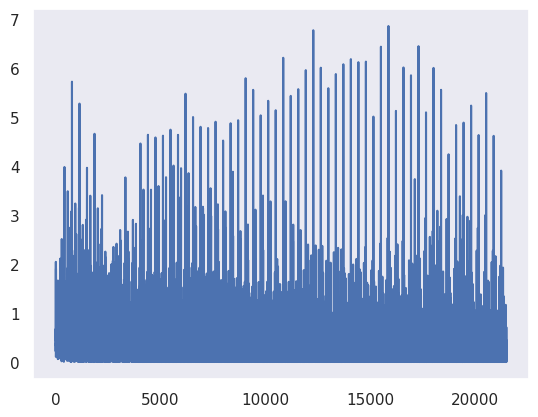

In [20]:
plt.plot(train_losses)

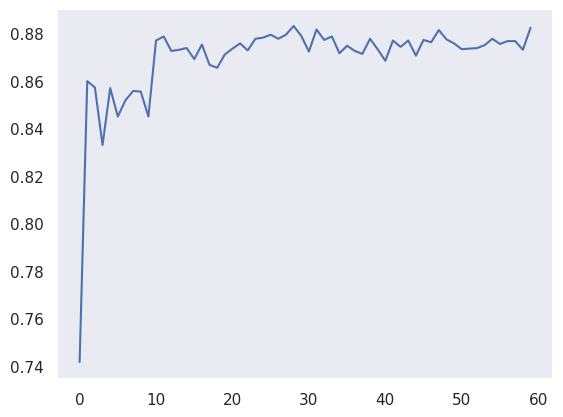

In [21]:
plt.plot(test_accuracy)

In [22]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3610/4064 (0.8883)
{'acc_detail': tensor([0.7699, 0.9254], device='cuda:0'),
 'acc_unweighted': tensor(0.8476, device='cuda:0'),
 'acc_weighted': tensor(0.8883, device='cuda:0'),
 'f1s_detail': tensor([0.7667, 0.9266], device='cuda:0'),
 'f1s_unweighted': tensor(0.8466, device='cuda:0'),
 'f1s_weighted': tensor(0.8884, device='cuda:0'),
 'precision_detail': tensor([0.7636, 0.9278], device='cuda:0'),
 'recall_detail': tensor([0.7699, 0.9254], device='cuda:0'),
 'rocauc': tensor(0.9427, device='cuda:0'),
 'rocauc_detail': tensor([0.9426, 0.9427], device='cuda:0'),
 'uar': tensor(0.8476, device='cuda:0'),
 'wap': tensor(0.8886, device='cuda:0')}


tensor([[ 746,  223],
        [ 231, 2864]], device='cuda:0')

In [23]:
model_path = f'{model_dir}physio16k_fold4_m13mfcc_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
checkpoint_path = f'{model_dir}physio16k_fold4_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    # 'best_epoch': best_epoch,
    # 'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)